# Repeater spectral analysis

In [57]:
%matplotlib inline

In [38]:
from __future__ import print_function
import pylab as pl
import numpy as np
import rtpipe, sdmpy
import rtlib_cython as rtlib
from astropy import coordinates
from scipy.optimize import curve_fit

In [3]:
# SNR from realfast using telcal gain solutions
snrdet = {'57623': 35.2, '57633_scan7': 119.3, '57633_scan13': 16.3, '57638': 9.9, '57643': 69.9,
         '57645': 11.1, '57646': 16.0, '57648': 17.6, '57649': 25.2} 

# flux scale from Bryan
calstring = """2.0520    2.89698    0.00279
2.1800    *******    *******
2.3080    *******    *******
2.4360    3.53585    0.00377
2.5640    3.69554    0.00376
2.6920    3.85507    0.00423
2.8200    4.00438    0.00486
2.9480    4.11069    0.00562
3.0520    4.20375    0.00631
3.1800    4.29385    0.00662
3.3080    4.36557    0.00715
3.4360    4.43684    0.00786
3.5640    4.46937    0.00850
3.6920    4.52488    0.00860
3.8200    4.53571    0.00969
3.9480    4.54625    0.00859""" 
# parse flux scale
freq = []
flux = []
eflux = []
for line in calstring.split('\n'): 
    if '*' not in line:
        result = line.split()
        freq.append(float(result[0]))
        flux.append(float(result[1]))
        eflux.append(float(result[2]))
calfreq = np.array(freq)
calflux = np.array(flux)
print(calfreq, calflux)

[ 2.052  2.436  2.564  2.692  2.82   2.948  3.052  3.18   3.308  3.436
  3.564  3.692  3.82   3.948] [ 2.89698  3.53585  3.69554  3.85507  4.00438  4.11069  4.20375  4.29385
  4.36557  4.43684  4.46937  4.52488  4.53571  4.54625]


## Functions to read and analyze data

In [4]:
def getscannum(sdmfile):
    sdm = rtpipe.parsesdm.getsdm(sdmfile)
    for scan in sdm.scans():
        try:
            print('Scan {0} binary data file: {1}'.format(scan.idx, scan.bdf.fname))
            bdfscan = int(scan.idx)
        except IOError:
            pass
    return bdfscan

def read_cut(sdmfile, scan, segment, dm=558., dt=1, gainfile=None, **kwargs):
    if not gainfile:
        gainfile = '.'.join(sdmfile.split('.')[:-1] + ['GN'])

    st = rtpipe.RT.set_pipeline(sdmfile, scan, dmarr=[dm], dtarr=[dt], flaglist=[('badap', 3., 0.2)], 
                                uvoversample=1.5, gainfile=gainfile, flagantsol=True, 
                                timesub='mean', logfile=False, savecands=False,
                                savenoise=False, **kwargs)
        
    data = rtpipe.RT.pipeline_reproduce(st, candloc=[segment,0,0,0,0], product='data')
    u, v, w = rtpipe.parsesdm.get_uvw_segment(st, segment)

    return st, data, u, v, w

def imloc(st, data, u, v, w, integ, verbose=0, weight='uniform'):
    if weight == 'uniform':
        weightarr = np.ones_like(data)
    elif weight == 'uvdist':
        uvd = np.sqrt(u**2+v**2)
        weightarr = np.ones_like(data)
        for bl in range(st['nbl']):
            weightarr[:,bl] *= uvd[bl]/uvd.max()

    im = rtpipe.RT.sample_image(st, data*weightarr, u, v, w, i=integ)
    l,m = rtpipe.RT.calc_lm(st, im)
    ra_center, dec_center = st['radec']
    ra, dec = rtpipe.reproduce.source_location(ra_center, dec_center, l, m)
    ras = ra.split()
    decs = dec.split()
    loc = coordinates.SkyCoord('{0}h{1}m{2}s'.format(ras[0], ras[1], ras[2]),
                               '{0}d{1}m{2}s'.format(decs[0], decs[1], decs[2]), frame='icrs')

    if verbose:
        print('Peak location:')
        print(l, m)
        print(loc.ra.hms, loc.dec.dms)
    return im, loc

def correctdata(st, data, u, v, w, corr='ph,dm', lm = (-3.85e-04,5.45e-04)):
    data2 = data.copy()
    
    if 'ph' in corr:
        l1, m1 = lm
        rtlib.phaseshift_threaded(data2, st, l1, m1, u, v)

    if 'dm' in corr:
        rtlib.dedisperse_par(data2, st['freq'], st['inttime'], st['dmarr'][0], [0, st['nbl']])
    
    return data2

# get array2 for bin in array near value
def find_nearest(array, array2, value):
    idx = (np.abs(array-value)).argmin()
    return array2[idx]

def getscale(st):
    # get flux scaling at nearest frequency
    scale = []
    for i in range(len(st['freq'])):
        freq = st['freq'][i]
        scale.append(find_nearest(calfreq, calflux, freq))
#         print(i, st['freq'][i], scale)
    scale = np.array(scale, dtype='complex64')[None,None,:,None]
    return scale

def correct_all(st, data, u, v, w):
    scale = getscale(st)
    dataph = correctdata(st, data*scale, u, v, w, corr='ph')
    dataphdm = correctdata(st, dataph, u, v, w, corr='dm')
    return dataphdm

def correct_and_plot(st, data, u, v, w, integ):
    scale = getscale(st)
    dataph = correctdata(st, data*scale, u, v, w, corr='ph')
    dataphdm = correctdata(st, dataph, u, v, w, corr='dm')

    fig = pl.figure(figsize=(15,8))
    ax = fig.add_subplot(131)
    sgram = dataphdm[integ-10:integ+10].mean(axis=3).mean(axis=1).real.transpose()
    pl.imshow(sgram, interpolation='nearest', origin='lower', cmap='viridis')
    pl.xlabel('Integration')
    pl.ylabel('Channel')
    ax = fig.add_subplot(132)
    spectra = dataphdm[integ-10:integ+10].mean(axis=2).mean(axis=1).real
    pl.plot(spectra[:,0], 'c.', label='RR')
    pl.plot(spectra[:,1], 'm.', label='LL')
    pl.legend()
    pl.xlabel('Integration')
    pl.ylabel('Amplitude')
    ax = fig.add_subplot(133)
    datadm = correctdata(st, data*scale, u, v, w, corr='dm')
    im, loc = imloc(st, datadm, u, v, w, integ, verbose=1)
    pl.imshow(im.transpose(), interpolation='nearest', cmap='viridis', aspect='equal')
    print('Image SNR {0}'.format(im.max()/im.std()))
    pl.xlabel('RA offset (pix)', fontsize=20)
    pl.ylabel('Dec offset (pix)', fontsize=20)
    xt = pl.setp(ax.get_xticklabels(), fontsize=14)
    yt = pl.setp(ax.get_yticklabels(), fontsize=14)
    ax.xaxis.set_tick_params(width=3, color='w')
    ax.yaxis.set_tick_params(width=3, color='w')

    fig = pl.figure(figsize=(3,6))
    ax = fig.add_subplot(111)
    sgram = dataph[integ-10:integ+50].mean(axis=3).mean(axis=1).real.transpose()
    extent = (0, 60*st['inttime'], st['freq'][0], st['freq'][-1])
    pl.imshow(sgram, interpolation='nearest', origin='lower', cmap='viridis',
              vmax=sgram.max()*0.8, extent=extent)
    pl.xlabel('Time (s, relative)', fontsize=14)
    pl.ylabel('Frequency (GHz)', fontsize=14)
    xt = pl.setp(ax.get_xticklabels(), fontsize=14)
    yt = pl.setp(ax.get_yticklabels(), fontsize=14)
    ax.xaxis.set_tick_params(width=2, color='k')
    ax.yaxis.set_tick_params(width=2, color='k')
    pl.xticks(np.linspace(0, 60*st['inttime'], 4))
    pl.colorbar()

    fig = pl.figure(figsize=(6,3))
    ax = fig.add_subplot(111)
    spectra = dataphdm[integ].mean(axis=0).real
    print('(RR-LL)/(RR+LL): {0}'.format(np.mean((spectra[:,0]-spectra[:,1])).real/np.mean((spectra[:,0]+spectra[:,1])).real))
    print('(RR+LL): {0}'.format(np.mean((spectra[:,0]+spectra[:,1])).real))
    nint, nbl, nch, npol = data.shape
    pl.scatter(range(0, nch), spectra[:,0], marker='.', c='c', label='RR', edgecolors='none')
    pl.scatter(range(0, nch), spectra[:,1], marker='.', c='m', label='LL', edgecolors='none')
    resamp = 16
    minch = 0
    if nch < 256:
        minch = resamp - (256-nch)
    print(minch, nch, resamp, spectra[minch:,0].shape)
    pl.scatter(range(minch, nch, resamp), spectra[minch:,0].reshape((256-minch)/resamp, resamp).mean(axis=1), 
               marker='_', c='c', s=500, edgecolors='c')
    pl.scatter(range(minch, nch, resamp), spectra[minch:,1].reshape((256-minch)/resamp, resamp).mean(axis=1), 
               marker='_', c='m', s=500, edgecolors='m')

    off = np.ma.masked_equal(dataphdm.mean(axis=1).real[range(0,integ-2)+range(integ+3,len(dataphdm))], 0)
    noise = off.std(axis=0)
    noiseRR = np.median(noise[:,0])
    noiseLL = np.median(noise[:,1])
    pl.errorbar(230, spectra.max(), yerr=noiseRR, fmt='c.', ecolor='c')
    pl.text(230, spectra.max(), s='RR', verticalalignment='center', horizontalalignment='left')
    pl.errorbar(240, spectra.max(), yerr=noiseLL, fmt='m.', ecolor='m')
    pl.text(240, spectra.max(), s='LL', verticalalignment='center', horizontalalignment='left')
#    pl.errorbar(range(nch), spectra[:,0], yerr=noise[:,0], fmt='c.', ecolor='c')
#    pl.errorbar(range(nch), spectra[:,1], yerr=noise[:,1], fmt='m.', ecolor='m')
#    pl.legend()
    pl.xlabel('Frequency (GHz)', fontsize=14)
    pl.ylabel('Flux density (Jy)', fontsize=14)
    pl.xlim(-5, nch+5)
    pl.xticks(range(0, nch+1, 32), [str(np.round(st['freq'][0]+ch*0.004, 2)) for ch in range(0, nch+1, 32)])
    xt = pl.setp(ax.get_xticklabels(), fontsize=14)
    yt = pl.setp(ax.get_yticklabels(), fontsize=14)
    ax.xaxis.set_tick_params(width=2, color='k')
    ax.yaxis.set_tick_params(width=2, color='k')
    return spectra

def getwidespectrum(st, data, u, v, w, i0, i1):
    scale = getscale(st)
    dataph = correctdata(st, data*scale, u, v, w, corr='ph')
    dataphdm = correctdata(st, dataph, u, v, w, corr='dm')
    spectrum = dataphdm[i0:i1].mean(axis=3).mean(axis=1).real
    return spectrum

def find_dm(st, data, u, v, w):
    scale = getscale(st)

    dmorig = st['dmarr']
    snrs = []
    for dm in range(530, 600, 2):
        st['dmarr'] = [dm]
        datadm = correctdata(st, data*scale, u, v, w, corr='dm')
        datadmph = correctdata(st, datadm, u, v, w, corr='ph')
        lc = datadmph.mean(axis=3).mean(axis=2).mean(axis=1).real
        integ = np.where(lc.max() == lc)[0][0]
        im, loc = imloc(st, datadm, u, v, w, integ)
        imc = im.transpose()[-1000:, 1000:]
        mad = np.median(np.abs(imc - np.median(imc)))
        std = mad/0.67
        snr = im.max()/std
        snrs.append((dm, integ, snr))
    st['dmarr'] = dmorig

    snrs = np.array(snrs)
    snrmax_ind = np.where(snrs[:,2] == snrs[:,2].max())[0][0]
    print('SNR vs DM: {0}'.format(snrs))
    print('Max SNR of {0} at DM={1}'.format(snrs[snrmax_ind, 2], snrs[snrmax_ind, 0]))
    return snrs[snrmax_ind]

In [5]:
read = {}
spectrum = {}
spectrumwide = {}
dmmax = {}

In [6]:
cd ~/16A-459/fastimaging/

/lustre/aoc/projects/16A-459/fastimaging


In [7]:
sdmfile = '16A-459_TEST_1hr.57623.72670021991.cut'
key = '57623'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 2, npix_max=4096)

2016-12-21 18:01:35,230 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-21 18:01:35,231 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-21 18:01:35,231 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-459_TEST_1hr.57623.72670021991.GN
2016-12-21 18:01:35,232 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-21 18:01:35,233 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-21 18:01:35,234 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 4096
2016-12-21 18:01:35,235 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2016-12-21 18:01:35,236 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2016-12-21 18:01:35,237 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2016-12-21 18:01:35,238 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2016-12-21 18:01:35,238 - rtpipe.parses

Scan 6 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-459_TEST_1hr.57623.72670021991.cut/ASDMBinary/uid____evla_bdf_1471974264507


2016-12-21 18:01:35,536 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14]
2016-12-21 18:01:35,610 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 6 of source FRB121102-off
2016-12-21 18:01:35,805 - rtpipe.parsesdm - INFO - 

2016-12-21 18:01:35,806 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-21 18:01:35,806 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-459_TEST_1hr.57623.72670021991.cut
2016-12-21 18:01:35,807 - rtpipe.parsesdm - INFO - 	 Using scan 6, source FRB121102-off
2016-12-21 18:01:35,808 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-21 18:01:35,809 - rtpipe.parsesdm - INFO - 	 Freq range (2.489 -- 3.509). 8 spw with 256 chans.
2016-12-21 18:01:35,810 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-21 18:01:35,811 - rtpipe.parsesdm - INFO - 	 2 polarizations: ['RR', 'LL']
2016-12-21 18:01:35,81

In [8]:
key = '57623'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)

Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.

Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Peak location:
-0.000382092830009 0.000539752492877
hms_tuple(h=5.0, m=31.0, s=58.726811858099168) dms_tuple(d=33.0, m=8.0, s=52.331952522986285)
Image SNR 35.9967785104
(RR-LL)/(RR+LL): -0.0121865458786
(RR+LL): 0.255277872086
0 256 16 (256,)
Image SNR (orig): 35.2


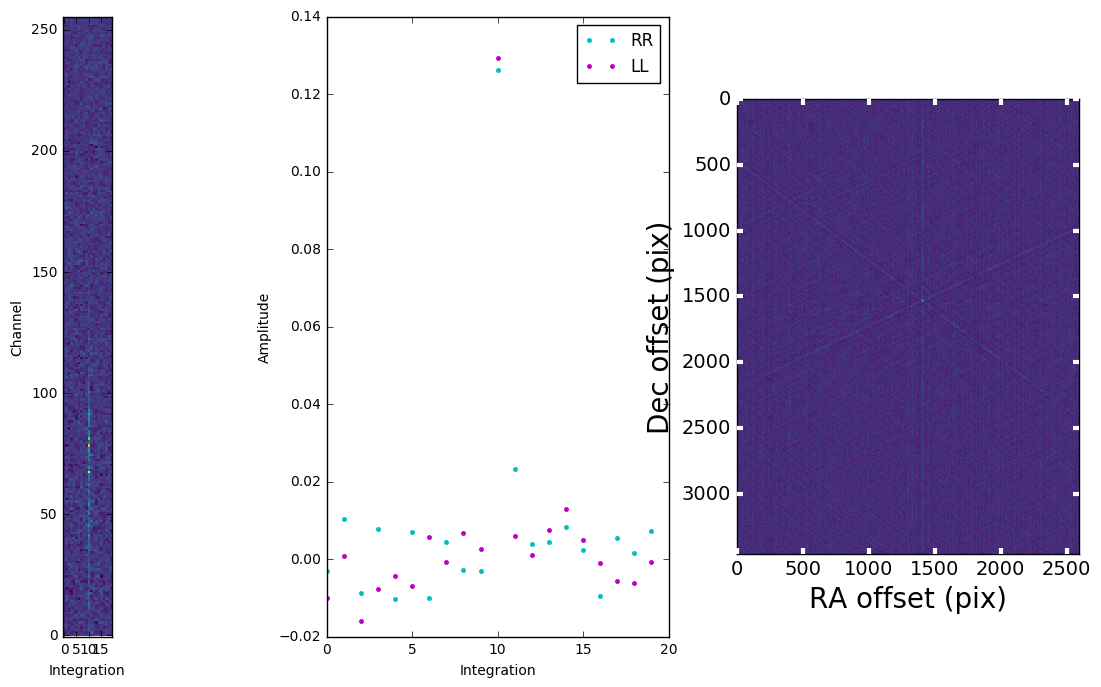

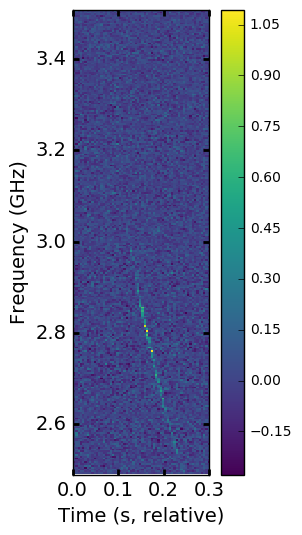

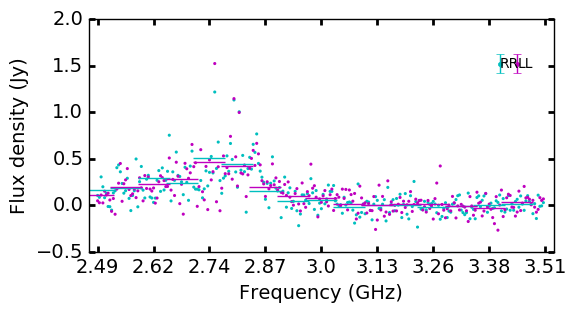

In [9]:
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [10]:
sdmfile = '16A-459_TEST_1hr_000.57633.66130137732.scan7.cut'
key = '57633_scan7'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 2, gainfile='16A-459_TEST_1hr_000.57633.66130137732.GN',
                               npix_max=4096)

2016-12-20 12:39:50,426 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-20 12:39:50,427 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-20 12:39:50,428 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-459_TEST_1hr_000.57633.66130137732.GN
2016-12-20 12:39:50,429 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-20 12:39:50,430 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-20 12:39:50,430 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 4096
2016-12-20 12:39:50,431 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2016-12-20 12:39:50,432 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2016-12-20 12:39:50,432 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2016-12-20 12:39:50,433 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2016-12-20 12:39:50,434 - rtpipe.pa

Scan 7 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-459_TEST_1hr_000.57633.66130137732.scan7.cut/ASDMBinary/uid____evla_bdf_1472832853393


2016-12-20 12:39:50,727 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]
2016-12-20 12:39:50,797 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 7 of source FRB121102-off
2016-12-20 12:39:50,895 - rtpipe.parsesdm - INFO - 

2016-12-20 12:39:50,896 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-20 12:39:50,897 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-459_TEST_1hr_000.57633.66130137732.scan7.cut
2016-12-20 12:39:50,897 - rtpipe.parsesdm - INFO - 	 Using scan 7, source FRB121102-off
2016-12-20 12:39:50,898 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-20 12:39:50,899 - rtpipe.parsesdm - INFO - 	 Freq range (2.489 -- 3.509). 8 spw with 256 chans.
2016-12-20 12:39:50,900 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-20 12:39:50,900 - rtpipe.parsesdm - INFO - 	 2 polarizations: ['RR', 'LL']
2016-12-20 1

Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 60.0
Pixel sizes (1.4", 1.1"), Field size 1983.3"
Gridded 1.

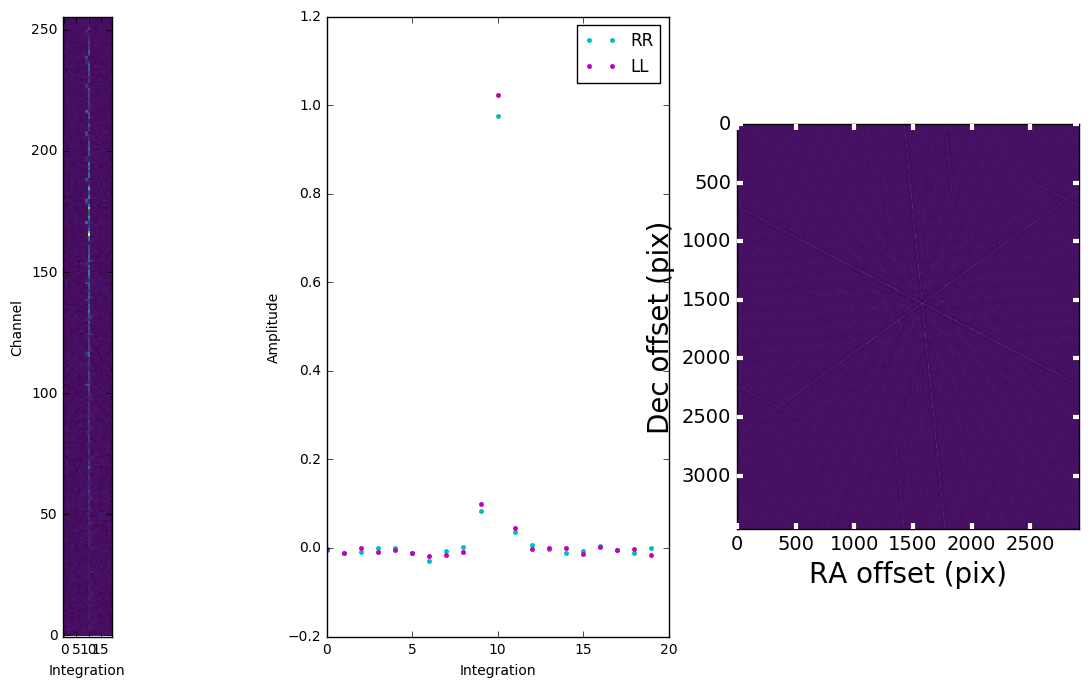

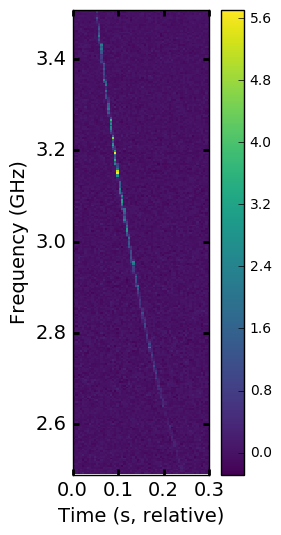

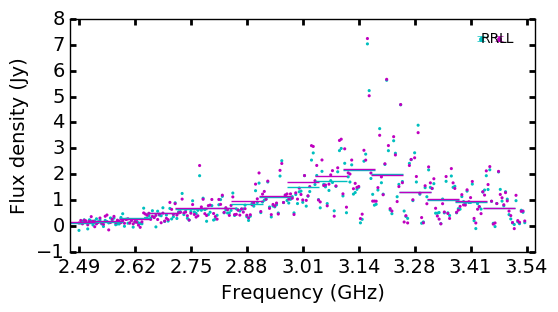

In [11]:
key = '57633_scan7'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [12]:
sdmfile = '16A-459_TEST_1hr_000.57633.66130137732.scan13.cut'
key = '57633_scan13'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 2, gainfile='16A-459_TEST_1hr_000.57633.66130137732.GN', npix_max=4096)

2016-12-20 12:41:45,495 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-20 12:41:45,496 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-20 12:41:45,497 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-459_TEST_1hr_000.57633.66130137732.GN
2016-12-20 12:41:45,498 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-20 12:41:45,499 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-20 12:41:45,500 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 4096
2016-12-20 12:41:45,501 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2016-12-20 12:41:45,501 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2016-12-20 12:41:45,502 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2016-12-20 12:41:45,503 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2016-12-20 12:41:45,504 - rtpipe.pa

Scan 13 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-459_TEST_1hr_000.57633.66130137732.scan13.cut/ASDMBinary/uid____evla_bdf_1472834169774


2016-12-20 12:41:45,820 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]
2016-12-20 12:41:45,898 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 13 of source FRB121102-off
2016-12-20 12:41:46,001 - rtpipe.parsesdm - INFO - 

2016-12-20 12:41:46,002 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-20 12:41:46,003 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-459_TEST_1hr_000.57633.66130137732.scan13.cut
2016-12-20 12:41:46,004 - rtpipe.parsesdm - INFO - 	 Using scan 13, source FRB121102-off
2016-12-20 12:41:46,004 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-20 12:41:46,005 - rtpipe.parsesdm - INFO - 	 Freq range (2.489 -- 3.509). 8 spw with 256 chans.
2016-12-20 12:41:46,006 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-20 12:41:46,007 - rtpipe.parsesdm - INFO - 	 2 polarizations: ['RR', 'LL']
2016-12-20

Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 51.8
Pixel sizes (1.5", 1.1"), Field size 1983.3"
Gridded 1.

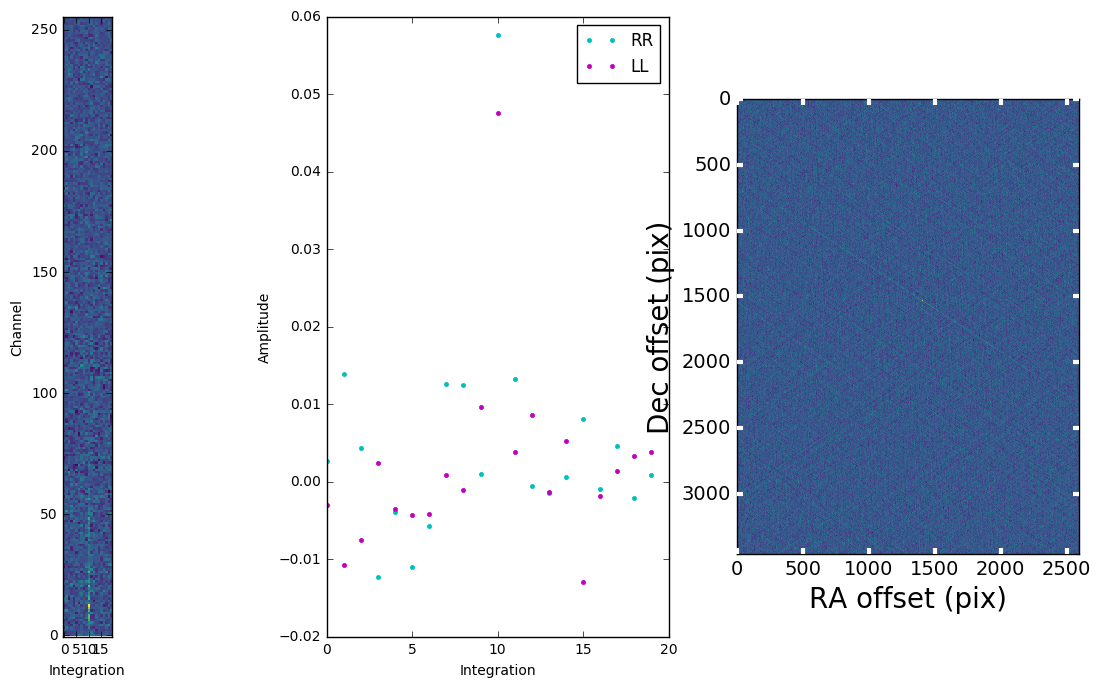

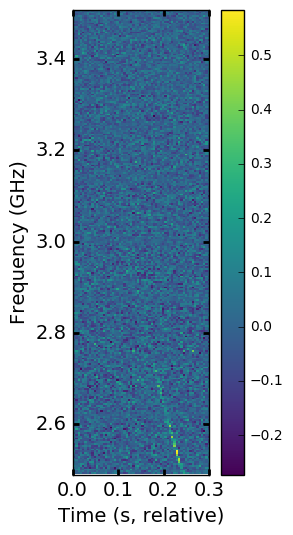

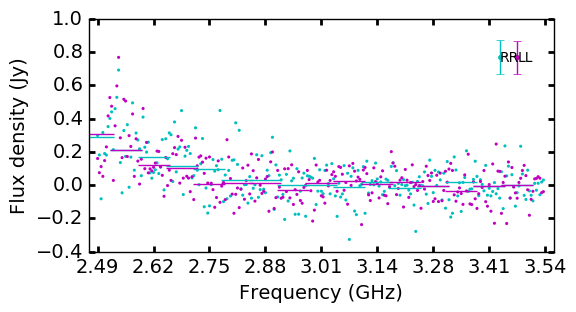

In [13]:
key = '57633_scan13'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [14]:
sdmfile = '16A-496_sb32698778_1_02h00m.57638.42695471065.cut'
key = '57638'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 4, npix_max=5500, chans=range(2,256))

2016-12-20 12:43:28,185 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-20 12:43:28,186 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-20 12:43:28,187 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m.57638.42695471065.GN
2016-12-20 12:43:28,188 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-20 12:43:28,189 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-20 12:43:28,189 - rtpipe.parsesdm - INFO - Setting (standard) key chans to [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107

Scan 29 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m.57638.42695471065.cut/ASDMBinary/uid____evla_bdf_1473249228150


2016-12-20 12:43:28,718 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33]
2016-12-20 12:43:28,851 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 29 of source FRB121102-off
2016-12-20 12:43:29,004 - rtpipe.parsesdm - INFO - 

2016-12-20 12:43:29,005 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-20 12:43:29,006 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m.57638.42695471065.cut
2016-12-20 12:43:29,007 - rtpipe.parsesdm - INFO - 	 Using scan 29, source FRB121102-off
2016-12-20 12:43:29,008 - rtpipe.parsesdm - INFO - 	 nants, nbl: 26, 325
2016-12-20 12:43:29,009 - rtpipe.parsesdm - INFO - 	 Freq range (2.497 -- 3.509). 8 spw with 254 chans.
2016-12-20 12:43:29,009 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-20 12:43:

Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 127.3
Pixel sizes (1.1", 0.7"), Field size 1983.3"

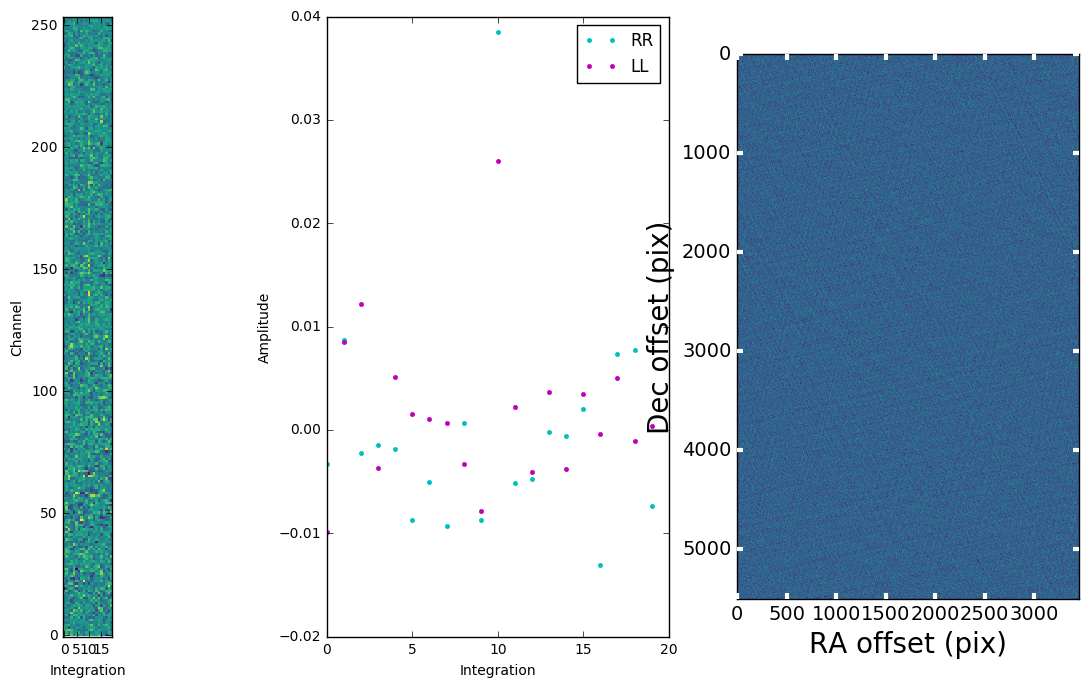

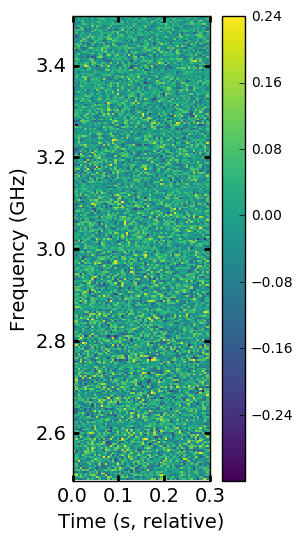

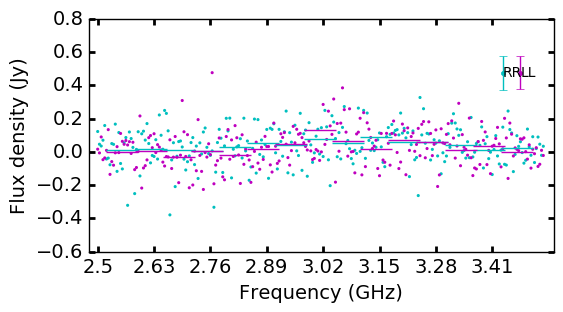

In [15]:
key = '57638'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [16]:
sdmfile = '16A-496_sb32698778_1_02h00m_001.57643.38562630787.cut/'
key = '57643'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 4, npix_max=5500)

2016-12-20 12:45:22,200 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-20 12:45:22,201 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-20 12:45:22,202 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_001.57643.38562630787.GN
2016-12-20 12:45:22,203 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-20 12:45:22,204 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-20 12:45:22,205 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 5500
2016-12-20 12:45:22,206 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2016-12-20 12:45:22,206 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2016-12-20 12:45:22,207 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2016-12-20 12:45:22,208 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2016-12-20 12:45:22,209 

Scan 29 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m_001.57643.38562630787.cut/ASDMBinary/uid____evla_bdf_1473677657337


2016-12-20 12:45:22,730 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33]
2016-12-20 12:45:22,860 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 29 of source FRB121102-off
2016-12-20 12:45:23,009 - rtpipe.parsesdm - INFO - 

2016-12-20 12:45:23,010 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-20 12:45:23,011 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m_001.57643.38562630787.cut
2016-12-20 12:45:23,012 - rtpipe.parsesdm - INFO - 	 Using scan 29, source FRB121102-off
2016-12-20 12:45:23,013 - rtpipe.parsesdm - INFO - 	 nants, nbl: 26, 325
2016-12-20 12:45:23,013 - rtpipe.parsesdm - INFO - 	 Freq range (2.489 -- 3.509). 8 spw with 256 chans.
2016-12-20 12:45:23,014 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-20 12

Gridded 1.000 of data. Scaling fft by = 180.2
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 179.9
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 180.0
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 179.6
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 180.1
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 180.0
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 179.8
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 180.0
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 179.8
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 179.0
Pixel sizes (0.9", 0.7"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 178.9
Pixel sizes (0.9", 0.7"), Field size 1983.3"

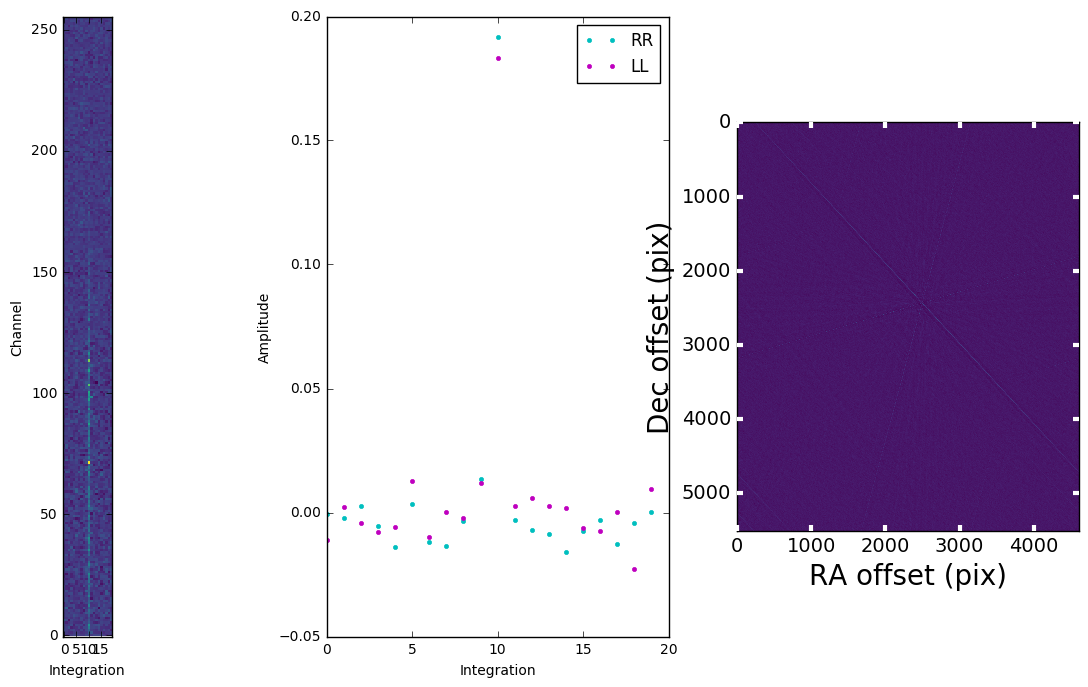

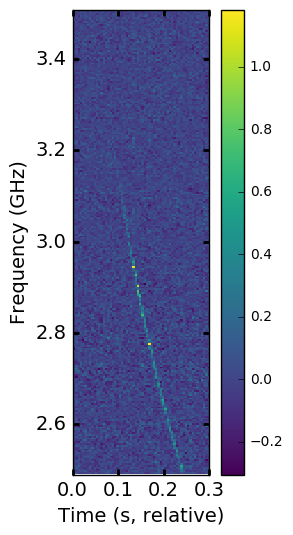

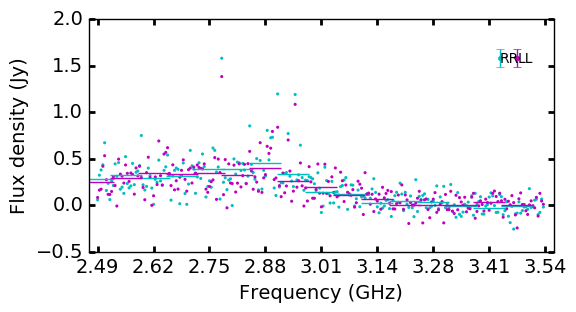

In [17]:
key = '57643'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [18]:
sdmfile = '16A-496_sb32698778_1_02h00m.57645.38915079861.cut'
key = '57645'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 6, npix_max=6500, chans=range(4,256))

2016-12-20 12:47:32,329 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-20 12:47:32,330 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-20 12:47:32,331 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m.57645.38915079861.GN
2016-12-20 12:47:32,331 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-20 12:47:32,332 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-20 12:47:32,333 - rtpipe.parsesdm - INFO - Setting (standard) key chans to [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108,

Scan 16 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m.57645.38915079861.cut/ASDMBinary/uid____evla_bdf_1473848163356


2016-12-20 12:47:32,872 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
2016-12-20 12:47:33,000 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 16 of source FRB121102-off
2016-12-20 12:47:33,156 - rtpipe.parsesdm - INFO - 

2016-12-20 12:47:33,157 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-20 12:47:33,158 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m.57645.38915079861.cut
2016-12-20 12:47:33,159 - rtpipe.parsesdm - INFO - 	 Using scan 16, source FRB121102-off
2016-12-20 12:47:33,160 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-20 12:47:33,161 - rtpipe.parsesdm - INFO - 	 Freq range (2.505 -- 3.509). 8 spw with 252 chans.
2016-12-20 12:47:33,162 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-20 12:47:

Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 250.3
Pixel sizes (0.6", 0.6"), Field size 1983.3"

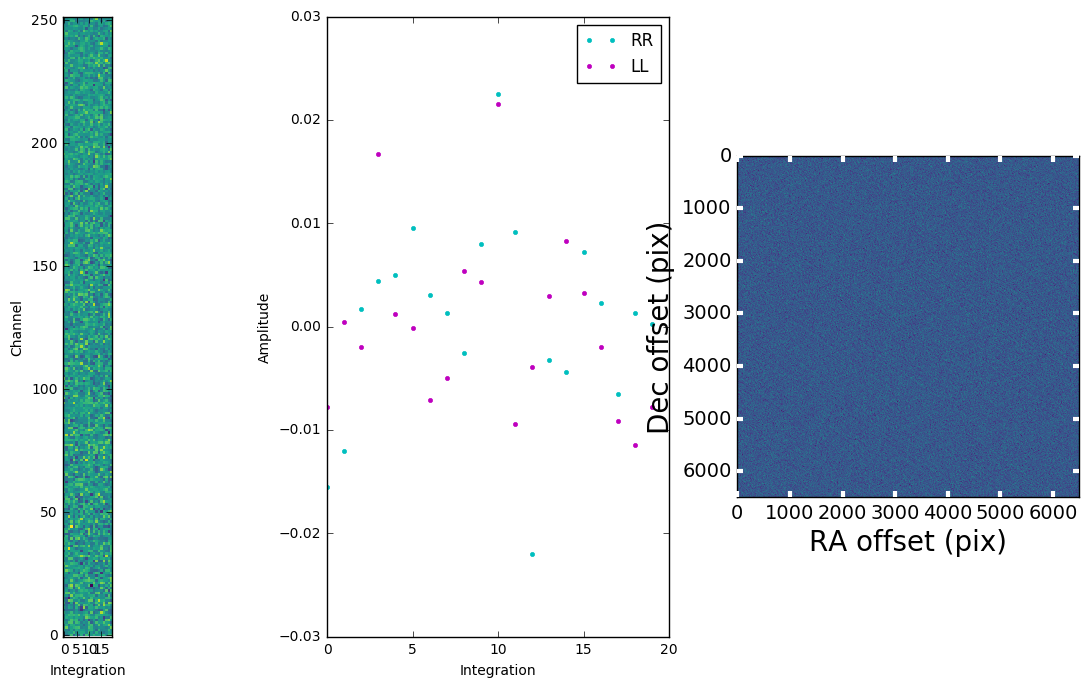

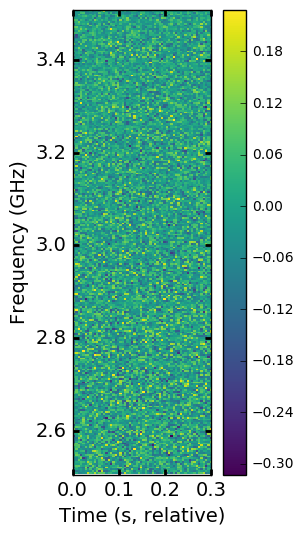

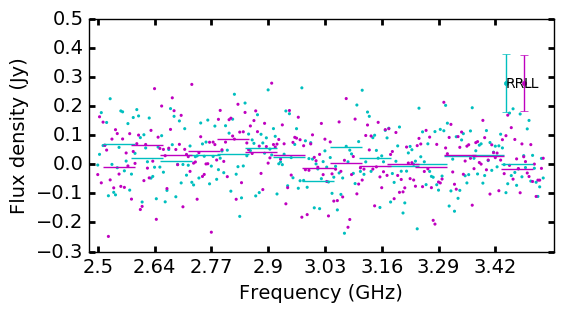

In [19]:
key = '57645'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [20]:
sdmfile = '16A-496_sb32698778_1_02h00m_000.57646.38643644676.cut'
key = '57646'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 6, npix_max=7000, chans=range(3,256))

2016-12-20 12:50:32,418 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-20 12:50:32,419 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-20 12:50:32,420 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_000.57646.38643644676.GN
2016-12-20 12:50:32,421 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-20 12:50:32,422 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-20 12:50:32,423 - rtpipe.parsesdm - INFO - Setting (standard) key chans to [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 10

Scan 32 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m_000.57646.38643644676.cut/ASDMBinary/uid____evla_bdf_1473937600955


2016-12-20 12:50:32,953 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33]
2016-12-20 12:50:33,077 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 32 of source FRB121102-off
2016-12-20 12:50:33,231 - rtpipe.parsesdm - INFO - 

2016-12-20 12:50:33,232 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-20 12:50:33,233 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m_000.57646.38643644676.cut
2016-12-20 12:50:33,234 - rtpipe.parsesdm - INFO - 	 Using scan 32, source FRB121102-off
2016-12-20 12:50:33,235 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-20 12:50:33,235 - rtpipe.parsesdm - INFO - 	 Freq range (2.501 -- 3.509). 8 spw with 253 chans.
2016-12-20 12:50:33,236 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-20 12

Gridded 1.000 of data. Scaling fft by = 304.7
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.4
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.7
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.6
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.6
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.7
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 304.8
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 302.8
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 302.7
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 303.1
Pixel sizes (0.6", 0.6"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 302.9
Pixel sizes (0.6", 0.6"), Field size 1983.3"

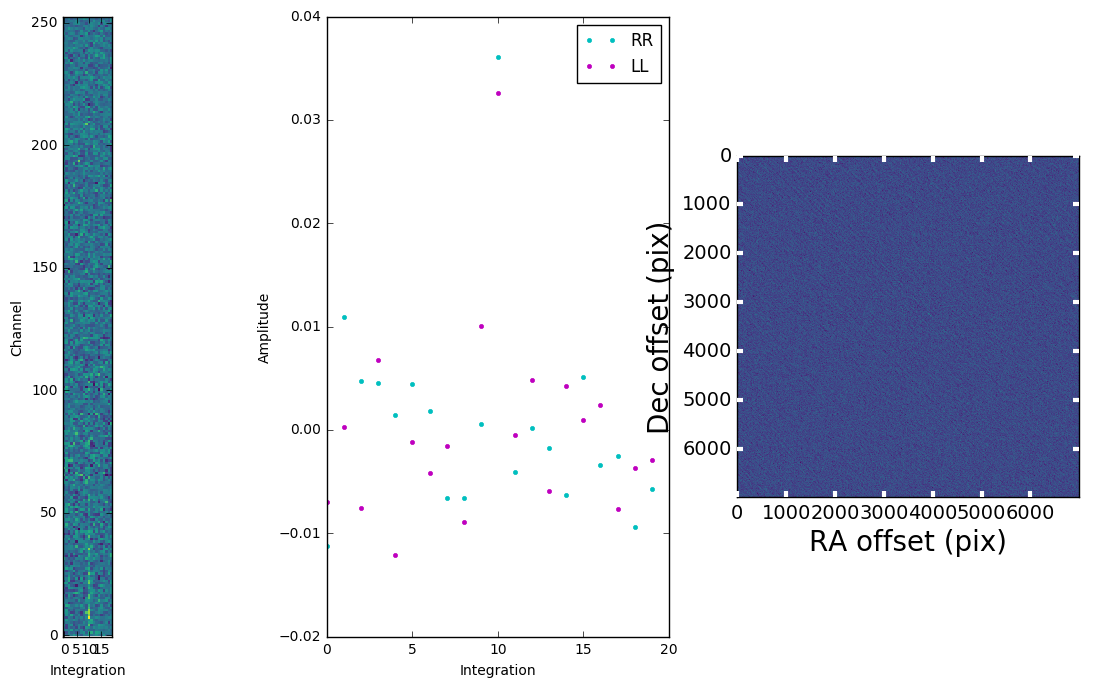

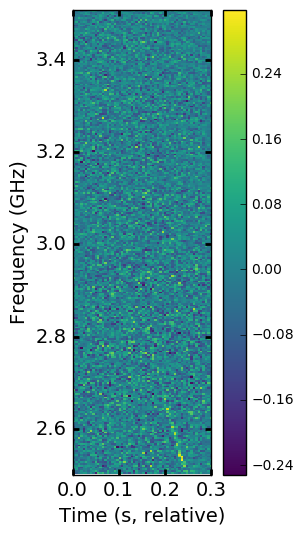

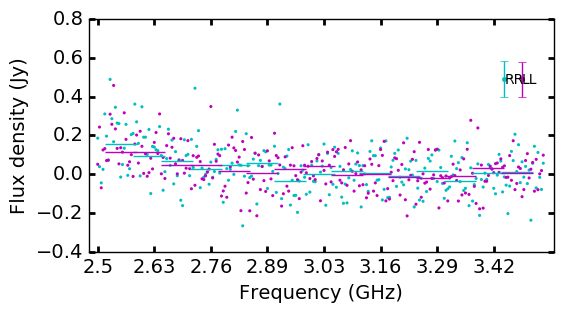

In [21]:
key = '57646'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [22]:
sdmfile = '16A-496_sb32698778_1_02h00m_000.57648.37452900463.cut/'
key = '57648'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 7, npix_max=7400, chans=range(2,256))

2016-12-20 12:53:41,186 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-20 12:53:41,187 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-20 12:53:41,188 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_000.57648.37452900463.GN
2016-12-20 12:53:41,189 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-20 12:53:41,190 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-20 12:53:41,191 - rtpipe.parsesdm - INFO - Setting (standard) key chans to [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,

Scan 25 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m_000.57648.37452900463.cut/ASDMBinary/uid____evla_bdf_1474107905881


2016-12-20 12:53:41,722 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33]
2016-12-20 12:53:41,851 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 25 of source FRB121102-off
2016-12-20 12:53:42,007 - rtpipe.parsesdm - INFO - 

2016-12-20 12:53:42,008 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-20 12:53:42,009 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m_000.57648.37452900463.cut
2016-12-20 12:53:42,010 - rtpipe.parsesdm - INFO - 	 Using scan 25, source FRB121102-off
2016-12-20 12:53:42,011 - rtpipe.parsesdm - INFO - 	 nants, nbl: 27, 351
2016-12-20 12:53:42,012 - rtpipe.parsesdm - INFO - 	 Freq range (2.497 -- 3.509). 8 spw with 254 chans.
2016-12-20 12:53:42,012 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-20 12

Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 318.9
Pixel sizes (0.5", 0.5"), Field size 1983.3"

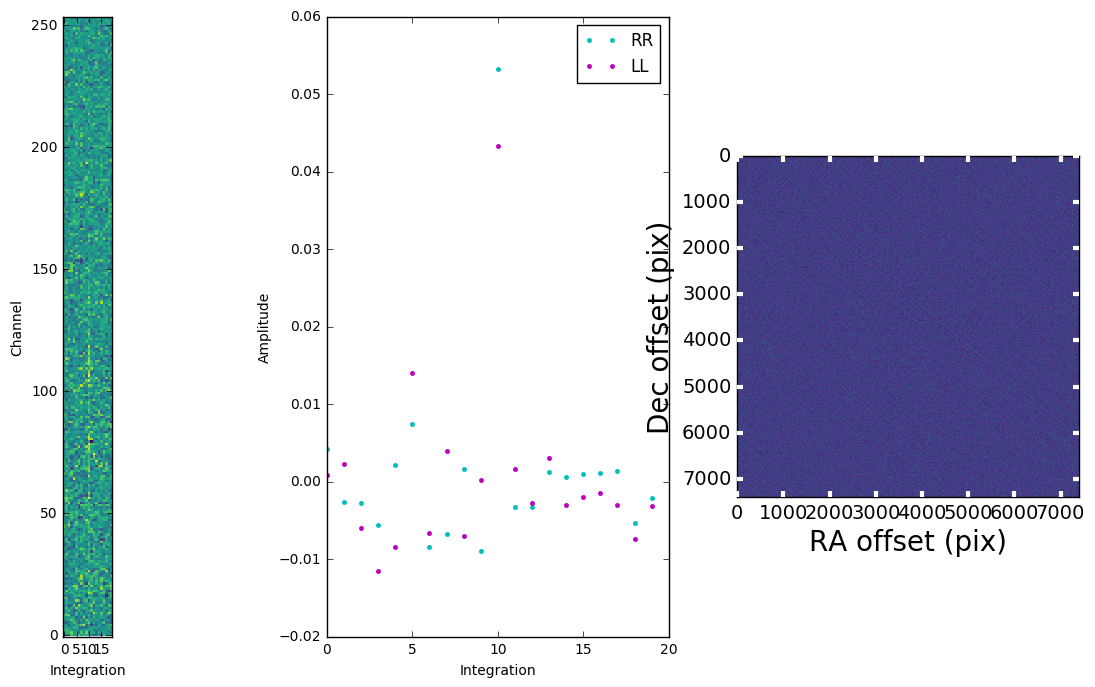

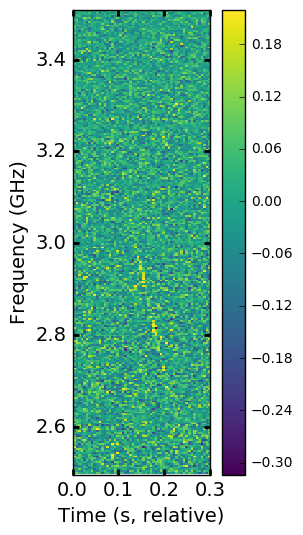

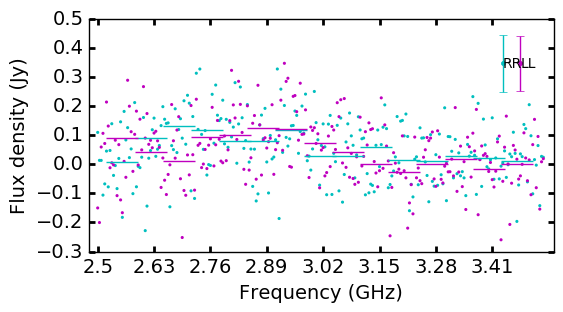

In [23]:
key = '57648'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

In [24]:
sdmfile = '16A-496_sb32698778_1_02h00m_001.57649.37461215278.cut/'
key = '57649'
scannum = getscannum(sdmfile)
read[key] = read_cut(sdmfile, scannum, 7, npix_max=7400)

2016-12-20 12:58:21,692 - rtpipe.parsesdm - INFO - Setting (standard) key logfile to False
2016-12-20 12:58:21,694 - rtpipe.parsesdm - INFO - Setting (standard) key timesub to mean
2016-12-20 12:58:21,695 - rtpipe.parsesdm - INFO - Setting (standard) key gainfile to 16A-496_sb32698778_1_02h00m_001.57649.37461215278.GN
2016-12-20 12:58:21,695 - rtpipe.parsesdm - INFO - Setting (standard) key dmarr to [558.0]
2016-12-20 12:58:21,696 - rtpipe.parsesdm - INFO - Setting (standard) key dtarr to [1]
2016-12-20 12:58:21,697 - rtpipe.parsesdm - INFO - Setting (standard) key npix_max to 7400
2016-12-20 12:58:21,698 - rtpipe.parsesdm - INFO - Setting (standard) key savecands to False
2016-12-20 12:58:21,699 - rtpipe.parsesdm - INFO - Setting (standard) key flaglist to [('badap', 3.0, 0.2)]
2016-12-20 12:58:21,700 - rtpipe.parsesdm - INFO - Setting (standard) key savenoise to False
2016-12-20 12:58:21,701 - rtpipe.parsesdm - INFO - Setting (standard) key flagantsol to True
2016-12-20 12:58:21,702 

Scan 31 binary data file: /lustre/aoc/projects/16A-459/fastimaging/16A-496_sb32698778_1_02h00m_001.57649.37461215278.cut/ASDMBinary/uid____evla_bdf_1474195554648


2016-12-20 12:58:22,219 - rtpipe.parsesdm - WARNING - No BDF found for scans [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33]
2016-12-20 12:58:22,347 - rtpipe.parsesdm - INFO - Calculating uvw for first integration of scan 31 of source FRB121102-off
2016-12-20 12:58:22,498 - rtpipe.parsesdm - INFO - 

2016-12-20 12:58:22,499 - rtpipe.parsesdm - INFO - Metadata summary:
2016-12-20 12:58:22,500 - rtpipe.parsesdm - INFO - 	 Working directory and data at /lustre/aoc/projects/16A-459/fastimaging, 16A-496_sb32698778_1_02h00m_001.57649.37461215278.cut
2016-12-20 12:58:22,501 - rtpipe.parsesdm - INFO - 	 Using scan 31, source FRB121102-off
2016-12-20 12:58:22,502 - rtpipe.parsesdm - INFO - 	 nants, nbl: 26, 325
2016-12-20 12:58:22,502 - rtpipe.parsesdm - INFO - 	 Freq range (2.489 -- 3.509). 8 spw with 256 chans.
2016-12-20 12:58:22,503 - rtpipe.parsesdm - INFO - 	 Scan has 800 ints (4.0 s) and inttime 0.005 s
2016-12-20 12

Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"
Gridded 1.000 of data. Scaling fft by = 342.2
Pixel sizes (0.5", 0.5"), Field size 1983.3"

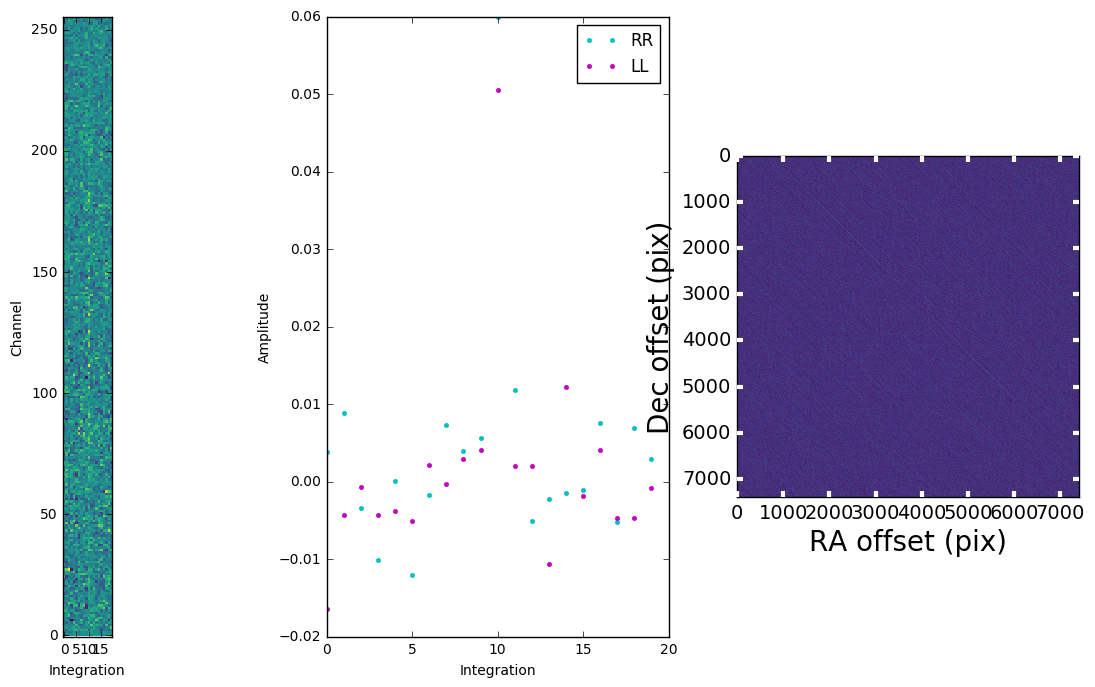

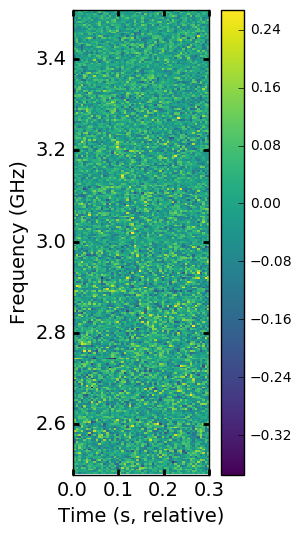

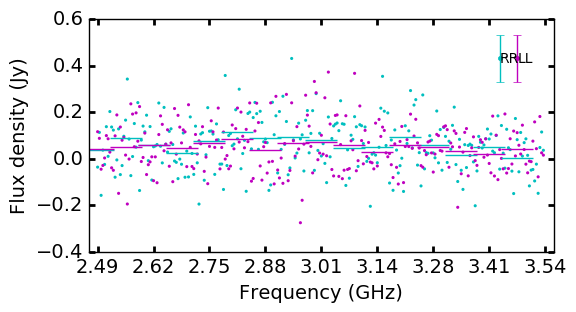

In [25]:
key = '57649'
st, data, u, v, w = read[key]
snrmax = find_dm(st, data, u, v, w)
dmmax[key] = snrmax
dm = snrmax[0]
integ = int(snrmax[1])
st['dmarr'] = [dm]
spectrum[key] = correct_and_plot(st, data, u, v, w, integ)
i0 = integ - 1
i1 = integ + 2
spectrumwide[key] = getwidespectrum(st, data, u, v, w, i0, i1)
print('Image SNR (orig): {0}'.format(snrdet[key]))

## Spectral autocorrelation

In [394]:
def plot_acf(st, data, u, v, w, integ):
    fig = pl.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    dataphdm = correct_all(st, data, u, v, w)
    spec = dataphdm[integ].mean(axis=2).mean(axis=0).real
    spec_off = dataphdm[integ+3].mean(axis=2).mean(axis=0).real
    ac = np.correlate(spec, spec, mode='same')
    ac_off = np.correlate(spec_off, spec_off, mode='same')
    pl.plot(ac, 'k.', label="Burst {0}".format(key))
    pl.plot(ac_off, 'c.', label="Off burst")   
    pl.xlabel('Delay (MHz)', fontsize=14)
    pl.ylabel('Autocorrelation power (Jy$^2$)', fontsize=14)
    xt = pl.setp(ax.get_xticklabels(), fontsize=14)
    yt = pl.setp(ax.get_yticklabels(), fontsize=14)
    ax.xaxis.set_tick_params(width=2, color='k')
    ax.yaxis.set_tick_params(width=2, color='k')
    pl.xticks(np.linspace(0, 256, 8), [str(int(4.0*(ch-128))) for ch in np.linspace(0, 256, 8)])
    pl.xlim(127.,256)
    pl.legend()

57633_scan7
57649
57638
57646
57633_scan13
57645
57648
57643
57623


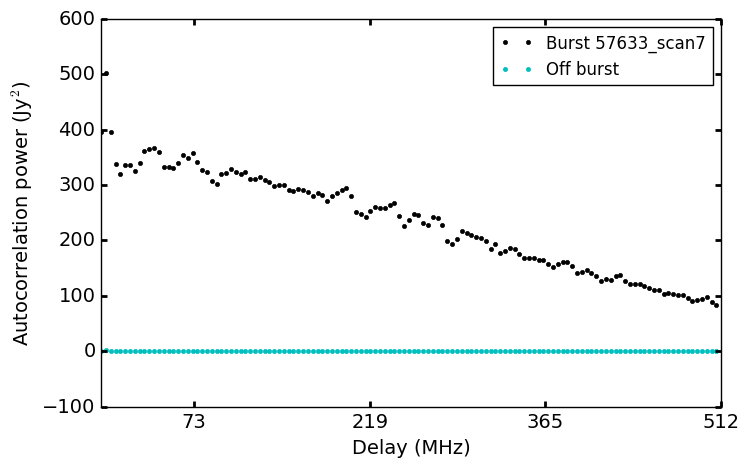

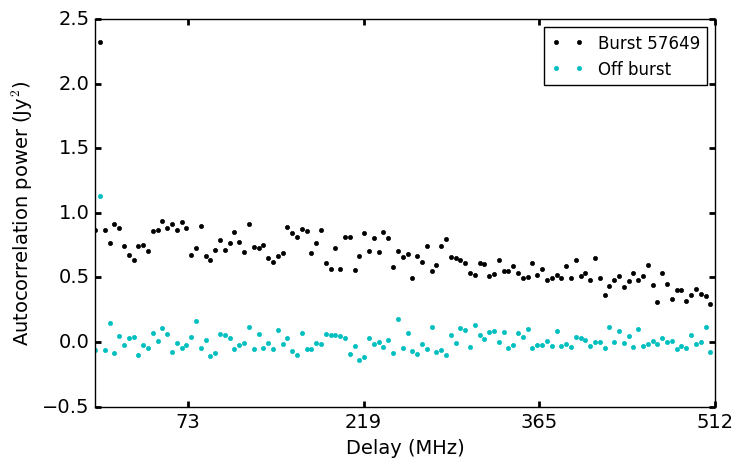

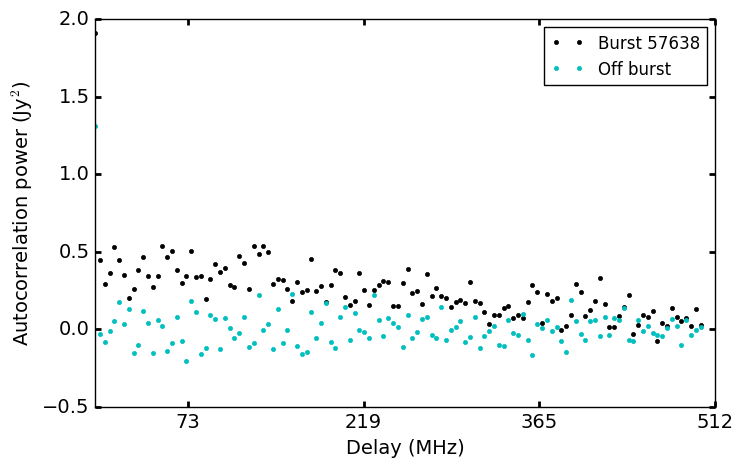

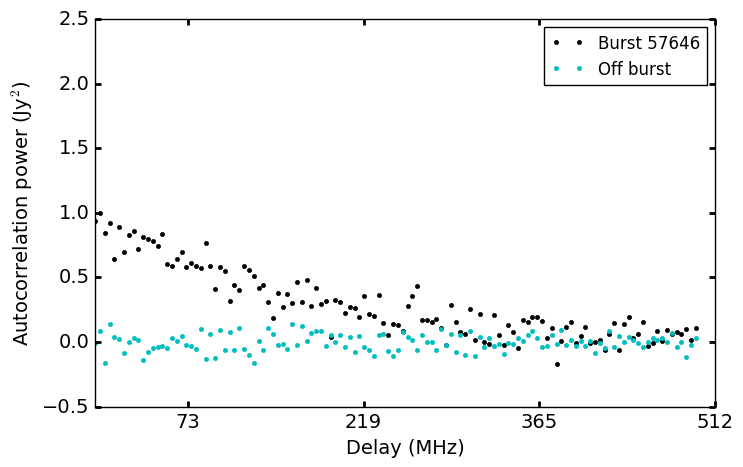

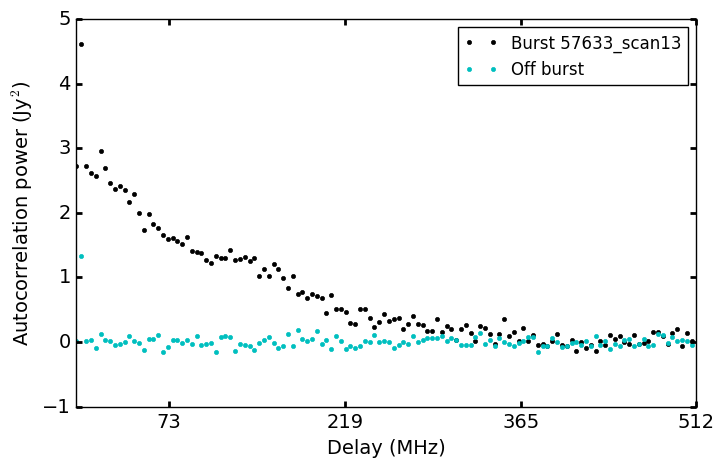

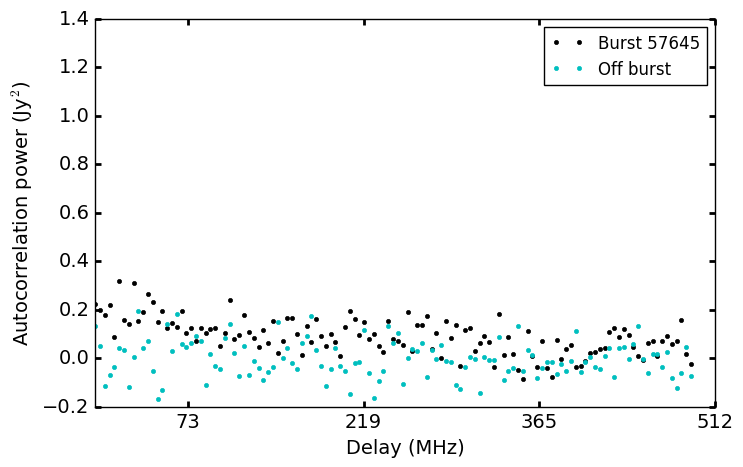

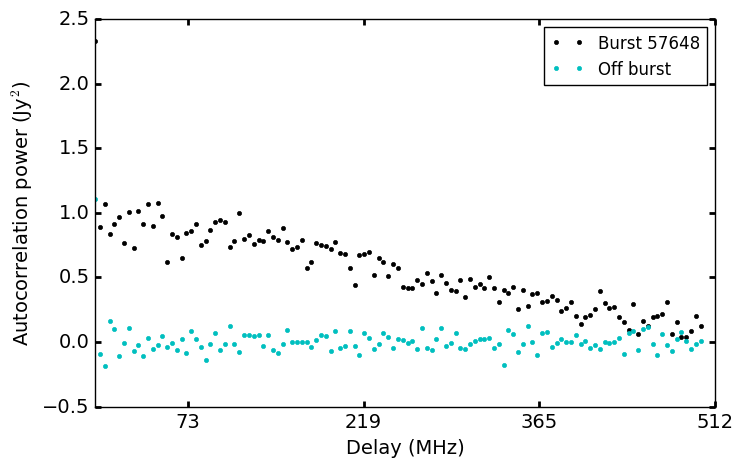

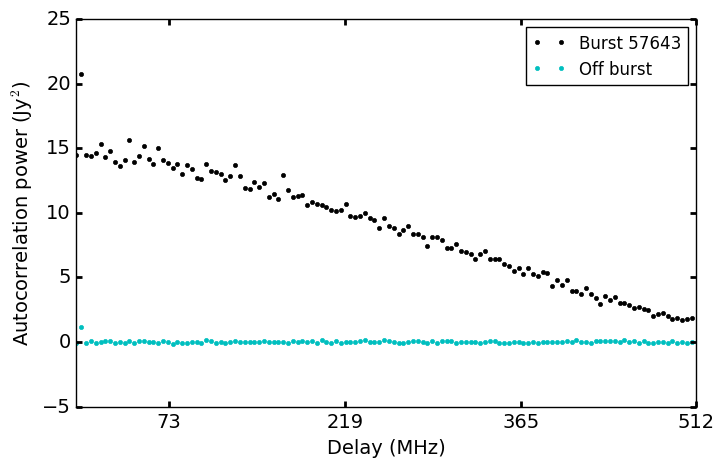

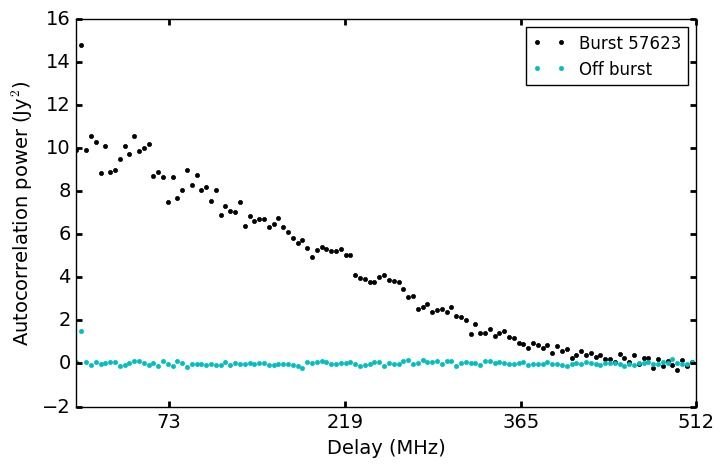

In [395]:
for key in snrdet.keys():
    print(key)
    integ = int(dmmax[key][1])
    st, data, u, v, w = read[key]
    plot_acf(st, data, u, v, w, integ)

## Spectral Modeling

In [10]:
import scipy.stats
from scipy.optimize import curve_fit

fbin = 4

sc = lambda sig: np.sqrt(2*sig**2*np.pi)
lum_s = lambda ld, s: s*1e-23 * (4*np.pi*ld**2) * 5e-3 * 1.024e9 # lum in erg, s in Jy, ld in cm
lum_ext = lambda ld, po: po[0]/sc(po[2])*1e-23 * (4*np.pi*ld**2) * 5e-3 * 2.355*fbin*4*po[2]*1e6 # lum in erg, s is norm fit peak in Jy, ld in cm

def norm(x, a, loc, scale):
    return a*scipy.stats.norm(loc, scale).pdf(x)

def fitandplot(spectrum, f0, popt_fixed=None, axis=()):

    # create binned spectrum
    nch0 = len(spectrum)
    spec = []
    for ch in range(0, nch0, fbin):
        spec.append(spectrum[ch:ch+fbin].mean())  # last bin may have fewer than 4 channels. go with it.
    spec = np.array(spec)
    nch = len(spec)
    print('Binned from {0} to {1} channels'.format(nch0, nch))
    
    if not popt_fixed:
        bounds = ([1, 0, 1], [2000, 256/fbin, 50])
        popt, pcov = curve_fit(norm, np.arange(nch), spec, bounds=bounds)
    else:
        popt = popt_fixed

    normsol = norm(np.linspace(0, nch, nch0), *popt)

    fig = pl.figure(figsize=(15,7))
    ax = fig.add_subplot(111)
#    pl.errorbar(range(fbin*nch), spectrum, fmt='c.', ecolor='c')
    pl.plot(range(nch0), spectrum, 'k.')
#    pl.plot(np.linspace(0, nch0, nch), spec, 'c*')
    pl.plot(np.arange(nch0), normsol, 'k')
    if len(axis):
        pl.axis(axis)
    pl.xlabel('Frequency (GHz)', fontsize=14)
    pl.ylabel('Flux density (Jy)', fontsize=14)
    pl.xlim(-4, nch0+4)
    pl.xticks(range(0, nch0+1, 32), [str(np.round(f0+ch*0.004, 2)) for ch in range(0, nch0+1, 32)])
    xt = pl.setp(ax.get_xticklabels(), fontsize=14)
    yt = pl.setp(ax.get_yticklabels(), fontsize=14)
    ax.xaxis.set_tick_params(width=2, color='k')
    ax.yaxis.set_tick_params(width=2, color='k')

    return popt


In [11]:
# full-res spectral fits
#popt = {'57623': [ 33.18660225 , 68.6786758  , 31.97989185],
#        '57633_scan7': [ 261.01468348,  163.37613653 ,  54.94315806],
#        '57633_scan13': [ 25.91234327 ,  0. , 36.83456147],
#        '57643': [ 54.70339027 , 68.70560927,  55.53711055],
#        '57649': [17.31563655, 104.88902813 ,  93.62882441],
#        '57638': [8.03104856,  159.12796452,   43.9087101 ],
#        '57646': [1.67436907e+01, 0.,  4.26219468e+01],
#        '57645': [3.63342113,  85.9990355,   22.58927418],
#        '57648': [ 12.25215549,  87.65698285,  44.20621731]}

# bin spectra by 4
popt = {'57633_scan7': [ 65.34364137,  40.53096697,  13.78088794],
       '57649': [  4.3092322,   25.87960046,  23.20757215],
       '57643': [ 13.77221702,  16.65750292,  13.9484172 ],
       '57638': [  2.02851581,  39.29549388,  11.28088088],
       '57646': [  3.98608102e+00, 0,   1.00213376e+01],
       '57633_scan13': [  6.40875573e+00,   0,   9.26735728e+00],
       '57645': [  1.17831665, 17.02810437,   9.24786317],
       '57648': [  3.05757414,  21.54651779, 11.21822984],
       '57623': [  8.30028279,  16.80016577 ,  8.00799541]}

57623
Binned from 256 to 64 channels
Already fit 57623 (peak, center, fwhm): 0.41 & 2.8 & 302
Energy: 7.12e+38
57633_scan13


KeyError: '57633_scan13'

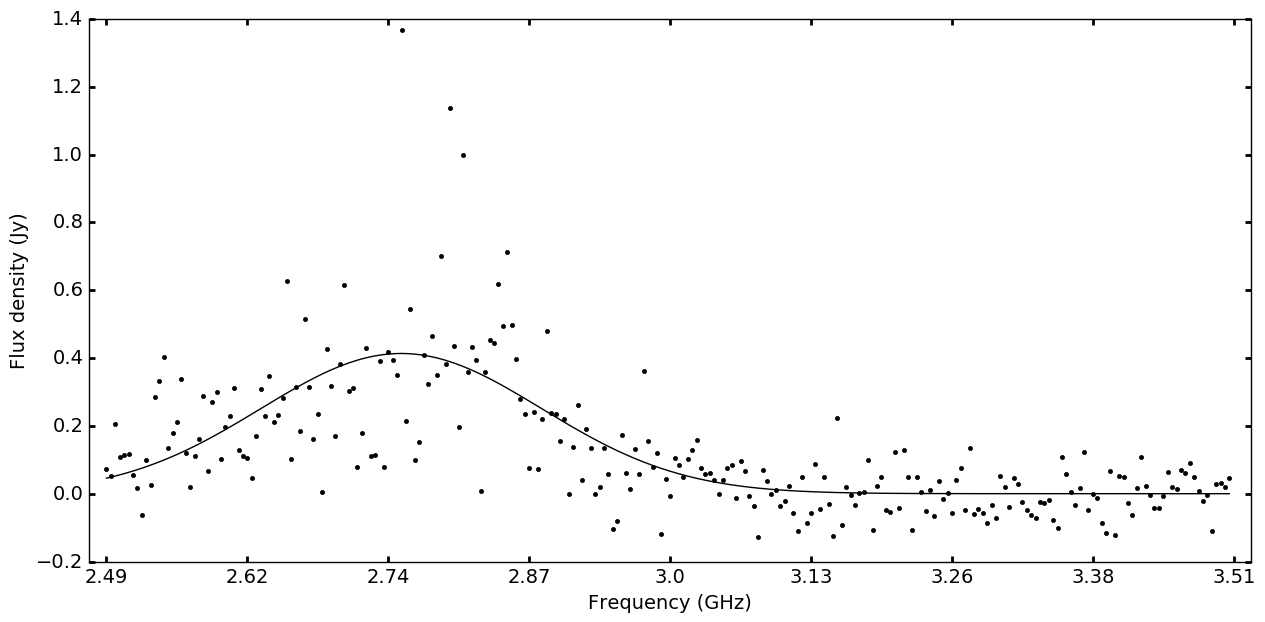

In [12]:
for key in sorted(snrdet.keys()):
    print(key)
    st, data, u, v, w = read[key]
    spec = spectrum[key].mean(axis=1)
    if key not in popt:
        po = fitandplot(spec, st['freq'][0])
        print(po)
        print('Fitting {0} (peak, center, fwhm): {1:.2f} & {2:.1f} & {3:.0f}'.format(key,
                                                                                  po[0]/sc(po[2]),
                                                                                  2.5+fbin*0.004*po[1],
                                                                                  np.round(2.355*fbin*4*po[2])), 2)
        break
    else:
        fitandplot(spec, st['freq'][0], popt_fixed=popt[key])
        po = popt[key]
        print('Already fit {0} (peak, center, fwhm): {1:.2f} & {2:.1f} & {3:.0f}'.format(key,
                                                                                  po[0]/sc(po[2]),
                                                                                  2.5+fbin*0.004*po[1],
                                                                                  np.round(2.355*fbin*4*po[2]), 2))
        print('Energy: {:1.2e}'.format(lum_ext(972e6*3.1e18, po)))

## Generative model of dispersion

In [327]:
def sample(sgram, spmod, freq, times, dms, indexes=[2], breakpoint=None):
    ny, nx = sgram.shape
    grid = np.zeros(shape=(len(times), len(dms), len(indexes)))
    std = np.ma.median(np.ma.abs(sgram[:,:times.min()] - np.ma.median(sgram[:,:times.min()])))/0.67
    print('Noise from MAD: {0}'.format(std))
    if breakpoint:
        ist, jst, kst = breakpoint
    else:
         ist, jst, kst = -1, -1, -1
        
    for i in range(len(times)):
        for j in range(len(dms)):
            for k in range(len(indexes)):
                model = genmodel(ny, nx, spmod, times[i], dms[j], freq, std, index=indexes[k])
#                diff = (sgram - model)/std  # use statistical error in measurement if using data as model
                diff = (sgram - model)/np.where(model < std, std, model)   # use scintillation "error" in spectrum
#                exp = rescale*np.exp(-(diff**2)/2)
#                grid[i,j,k] = np.ma.prod(np.ma.masked_where(model == 0, exp))
                grid[i,j,k] = np.ma.sum(np.ma.masked_where(model == 0, -(diff**2)/2))
                if k == kst:
                    break
            if j == jst:
                break
        if i == ist:
            break
    
    if breakpoint:
        print(i, j, k, times[i], dms[j], indexes[k])
        return exp
    else:
        return np.exp(grid-grid.max())
    
def genmodel(ny, nx, spmod, i0, dm, freq, std, index=2, dx=0.005):
    """ Generate a 2d model of a dispersed pulse """
    
#    model = np.random.normal(0, std, size=(ny, nx))
    model = np.zeros(shape=(ny, nx))
    delay = (4.2e-3 * dm * (1./freq**index - 1./freq[-1]**index))/dx
    normarr = norm(np.linspace(0, 64, ny), *spmod)  # use gaussian model
    for y in range(0, ny):
        timer = np.round(i0+delay[y], 0).astype(np.int16)
        f0 = 1 - (i0+delay[y] - timer)
        f1 = 1 - f0
        if timer < nx+1:
            model[y, timer] += f0*normarr[y] 
            model[y, timer+1] += f1*normarr[y] 

        # TODO: add finite time width
            
    return model

delay = lambda dm, index, freq: (4.2e-3 * dm * (1./freq**index - 1./freq[-1]**index))

spec_ci = {}

In [373]:
key = '57623'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(dmmax[key][1]-1, dmmax[key][1]+1, 100)
dms = np.linspace(552, 570, 200)
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms)[:,:,0]
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal(grid.transpose(), 0) # normalize and flip to get time horizontally

2016-12-21 11:16:20,264 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0731048966522
(100, 200) 0.0 1.0


95.6868686869 96.0707070707 557.969849246 564.753768844
Max at DM=563.668341709


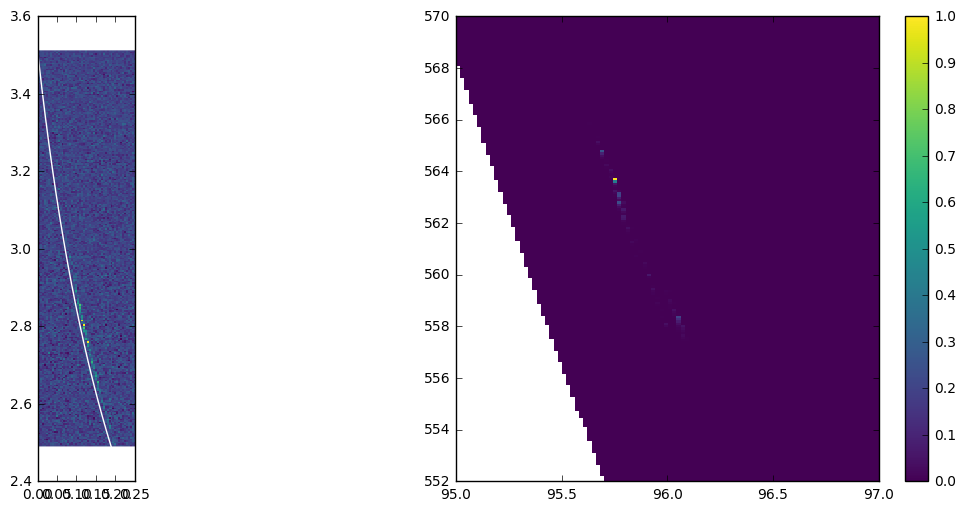

In [374]:
# find bounds
ci = 0.95
dmb, tb = np.where(grid > 1-ci)
dmm, tm = np.where(grid == grid.max())
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
print('Max at DM={0}'.format(dms[dmm[0]]))
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

pl.figure(figsize=(15,6))
pl.subplot(121)
t0 = int(times[0])
dt = 50*st['inttime']
extent = (0, dt, st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,t0:t0+50], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.plot(delay(dms[dmm[0]], 2, st['freq']), st['freq'], 'w-')
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis',
          extent=extent, aspect='auto')
pl.colorbar()

In [13]:
import emcee, corner

In [43]:
def lnlike1(theta, x, y, yerr):
    a, loc, scale = theta
    model = norm(x, a, loc, scale)
    return -0.5*(np.sum(((y-model)/yerr)**2))

def lnprior1(theta):
    a, loc, scale = theta
    if (0 < a < 100) and (0 < loc < 256) and (1 < scale < 256):
        return 0.
    return -np.inf

def lnprob1(theta, x, y, yerr):
    lp = lnprior1(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike1(theta, x, y, yerr)

In [44]:
spec = spectrum['57623'].mean(axis=1)
ndim, nwalkers = 3, 100
p0 = (30, 60, 60)
pos = [np.array(p0) + np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(np.arange(256), spec, 0.2))

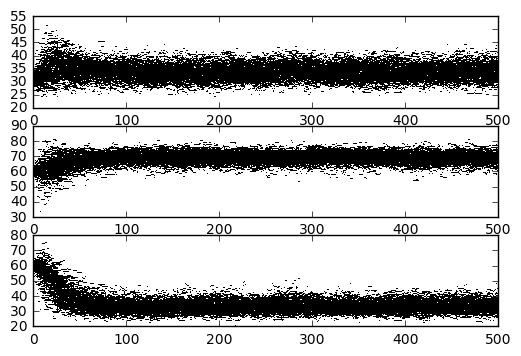

In [45]:
end = sampler.run_mcmc(pos, 500)

fig = pl.figure()
ax = fig.add_subplot(311)
plot = ax.plot(sampler.chain[...,0].transpose(), ',k')
ax = fig.add_subplot(312)
plot = ax.plot(sampler.chain[...,1].transpose(), ',k')
ax = fig.add_subplot(313)
plot = ax.plot(sampler.chain[...,2].transpose(), ',k')

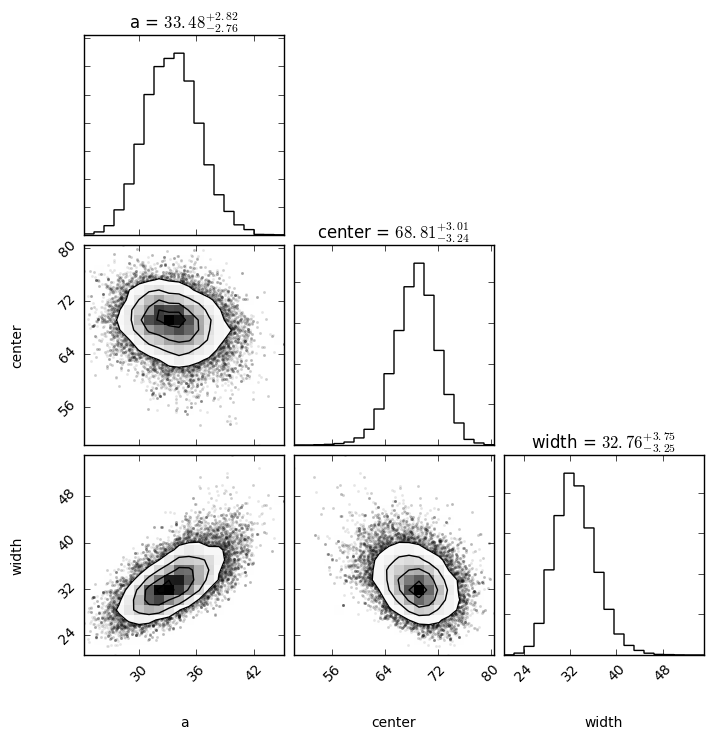

In [47]:
import corner
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["a", "center", "width"], show_titles=True)

In [157]:
freq0 = 3.5
freq = lambda y: 2.5 + 0.004*y

def normdm(x, y, a, loc, scale, i0, dm, dt=0.005):
    model = np.zeros(len(x[0]), dtype='float')
    normarr = a*scipy.stats.norm(loc, scale).pdf(y[:,0])
    delay = (4.2e-3 * dm * (1./freq(y[:,0])**2 - 1./freq0**2))
    
    i = np.round((i0 + delay)/dt, 0).astype(np.int16)
#    if i < len(x):
    print(model.shape, x[0].shape, y.shape, normarr.shape)
    model[x[0], i] += normarr
    return model

def lnlike(theta, x, y, z, zerr):
    a, loc, scale, i0, dm = theta
    model = normdm(x, y, a, loc, scale, i, dm)
    return -0.5*(np.sum(((z-model)/zerr)**2))

def lnprior(theta):
    a, loc, scale, i0, dm = theta
    if (0 < a < 100) and (0 < loc < 256) and (1 < scale < 256) and (90 < i0 < 100) and (550 < dm < 570):
        return 0.
    return -np.inf

def lnprob(theta, x, y, z, zerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, z, zerr)

In [158]:
x, y = np.meshgrid(np.arange(190), np.arange(256))

In [159]:
normdm(x, y, 1, 0, 100, 0, 0)

(190,) (190,) (256, 190) (256,)


IndexError: too many indices for array

In [136]:
key = '57623'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

ndim, nwalkers = 5, 100
p0 = (30, 60, 60, 95, 557)
pos = [np.array(p0) + np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, sgram, 0.073))

In [137]:
end = sampler.run_mcmc(pos, 10)

fig = pl.figure()
ax = fig.add_subplot(511)
plot = ax.plot(sampler.chain[...,0].transpose(), ',k')
ax = fig.add_subplot(512)
plot = ax.plot(sampler.chain[...,1].transpose(), ',k')
ax = fig.add_subplot(513)
plot = ax.plot(sampler.chain[...,2].transpose(), ',k')
ax = fig.add_subplot(514)
plot = ax.plot(sampler.chain[...,3].transpose(), ',k')
ax = fig.add_subplot(515)
plot = ax.plot(sampler.chain[...,4].transpose(), ',k')

emcee: Exception while calling your likelihood function:
  params: [  29.49957528   59.89822696   61.27284826   97.16987175  556.34385933]
  args: (array([[  0,   1,   2, ..., 187, 188, 189],
       [  0,   1,   2, ..., 187, 188, 189],
       [  0,   1,   2, ..., 187, 188, 189],
       ..., 
       [  0,   1,   2, ..., 187, 188, 189],
       [  0,   1,   2, ..., 187, 188, 189],
       [  0,   1,   2, ..., 187, 188, 189]]), array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ..., 
       [253, 253, 253, ..., 253, 253, 253],
       [254, 254, 254, ..., 254, 254, 254],
       [255, 255, 255, ..., 255, 255, 255]]), array([[  2.13664677e-02,   1.05041288e-01,   3.49122211e-02, ...,
         -8.06454918e-04,  -6.76124691e-05,  -7.90352374e-02],
       [  6.30719289e-02,  -1.94706507e-02,   9.25695375e-02, ...,
         -1.27673328e-01,  -4.34181020e-02,   1.50982302e-03],
       [ -5.06052040e-02,   3.7190

Traceback (most recent call last):
  File "/users/claw/miniconda/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-134-c13b125cef2c>", line 29, in lnprob
    return lp + lnlike(theta, x, y, z, zerr)
  File "<ipython-input-134-c13b125cef2c>", line 16, in lnlike
    model = normdm(x, y, a, loc, scale, i, dm)
  File "<ipython-input-134-c13b125cef2c>", line 11, in normdm
    model[x[0], i] += normarr[y[:,0]]
TypeError: Cannot cast ufunc add output from dtype('float64') to dtype('int64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc add output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [363]:
key = '57633_scan7'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(dmmax[key][1]-0, dmmax[key][1]+2, 50)
dms=np.linspace(550, 570, 100)
#grid = sample(sgram, spectrumwide[key].mean(axis=0)[None,:], st['freq'], times=times, dms=dms, rescale=1.1)[:,:,0]

grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms)[:,:,0]
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal(grid.transpose(), 0) # normalize and flip to get time horizontally horizontally

2016-12-21 11:11:04,497 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0694168147756
(50, 100) 1.19688767014e-293 1.0


97.0204081633 97.1020408163 559.898989899 562.121212121
Max at DM=559.898989899


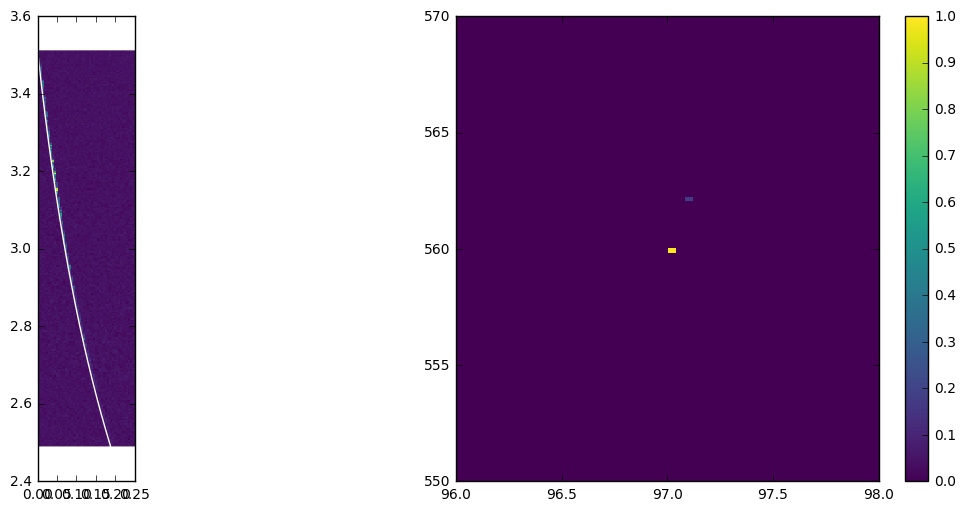

In [370]:
# find bounds
ci = 0.95
dmb, tb = np.where(grid > 1-ci)
dmm, tm = np.where(grid == grid.max())
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
print('Max at DM={0}'.format(dms[dmm[0]]))
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

pl.figure(figsize=(15,6))
pl.subplot(121)
t0 = int(times[0])
dt = 50*st['inttime']
extent = (0, dt, st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,t0:t0+50], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.plot(delay(dms[dmm[0]], 2, st['freq']), st['freq'], 'w-')
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis',
          extent=extent, aspect='auto')
pl.colorbar()

In [396]:
key = '57633_scan13'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(dmmax[key][1]-3, dmmax[key][1]+2, 100)
dms=np.linspace(500, 650, 150)
#grid = sample(sgram, spectrumwide[key].mean(axis=0)[None,:], st['freq'], times=times, dms=dms, rescale=1.1)[:,:,0]
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms)[:,:,0]
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal(grid.transpose(), 0) # normalize and flip to get time horizontally horizontally

2016-12-21 12:08:02,012 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0692616536546
(100, 150) 3.2072860874e-190 1.0


93.0505050505 94.8686868687 529.194630872 560.402684564
Max at DM=541.275167785, int=94.0101010101


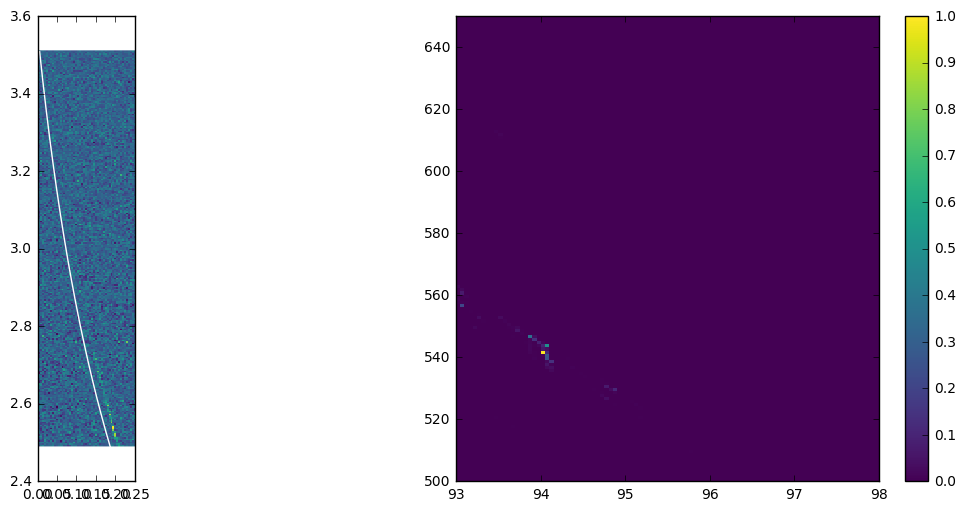

In [397]:
# find bounds
ci = 0.95
dmb, tb = np.where(grid > 1-ci)
dmm, tm = np.where(grid == grid.max())
print(times[tb.min()], times[tb.max()], dms[dmb.min()], dms[dmb.max()])
print('Max at DM={0}, int={1}'.format(dms[dmm[0]], times[tm[0]]))
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

pl.figure(figsize=(15,6))
pl.subplot(121)
t0 = int(times[0])
dt = 50*st['inttime']
extent = (0, dt, st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,t0:t0+50], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.plot(st['inttime']*(times[tm[0]]-t0)+delay(dms[dmm[0]], 2, st['freq']), st['freq'], 'w-')
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis',
          extent=extent, aspect='auto')
pl.colorbar()

In [334]:
key = '57638'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(dmmax[key][1]-1, dmmax[key][1]+1, 100)
dms=np.linspace(520, 580, 200)
#grid = sample(sgram, spectrumwide[key].mean(axis=0)[None,:], st['freq'], times=times, dms=dms, rescale=1.1)[:,:,0]
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms)[:,:,0]
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal(grid.transpose(), 0) # normalize and flip to get time horizontally

2016-12-20 18:18:29,733 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0707855475927
(100, 200) 8.2306768168e-49 1.0


60.7676767677 61.2929292929 537.487437186 550.753768844
Max at DM=539.296482412


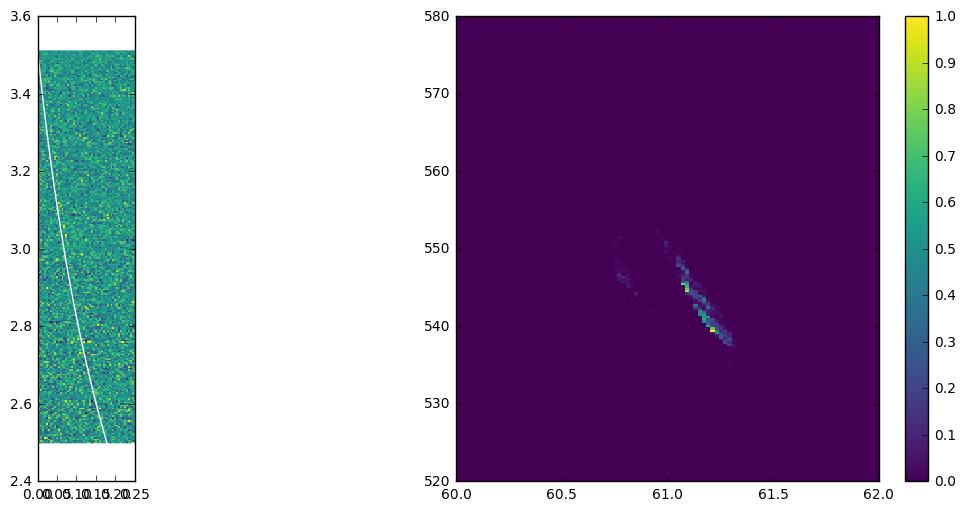

In [335]:
# find bounds
ci = 0.95
dmb, tb = np.where(grid > 1-ci)
dmm, tm = np.where(grid == grid.max())
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
print('Max at DM={0}'.format(dms[dmm[0]]))
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

pl.figure(figsize=(15,6))
pl.subplot(121)
t0 = int(times[0])
dt = 50*st['inttime']
extent = (0, dt, st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,t0:t0+50], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.plot(delay(dms[dmm[0]], 2, st['freq']), st['freq'], 'w-')
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis',
          extent=extent, aspect='auto')
pl.colorbar()

In [336]:
key = '57643'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(dmmax[key][1]-0.5, dmmax[key][1]+0.5, 100)
dms=np.linspace(552, 559, 250)
#grid = sample(sgram, spectrumwide[key].mean(axis=0)[None,:], st['freq'], times=times, dms=dms, rescale=1.1)[:,:,0]
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms)[:,:,0]
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal((grid/grid.max()).transpose(), 0) # normalize and flip to get time horizontally

2016-12-20 18:20:10,641 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0662440739906
(100, 250) 0.0 1.0


61.9747474747 62.0858585859 554.83935743 556.947791165
Max at DM=555.654618474


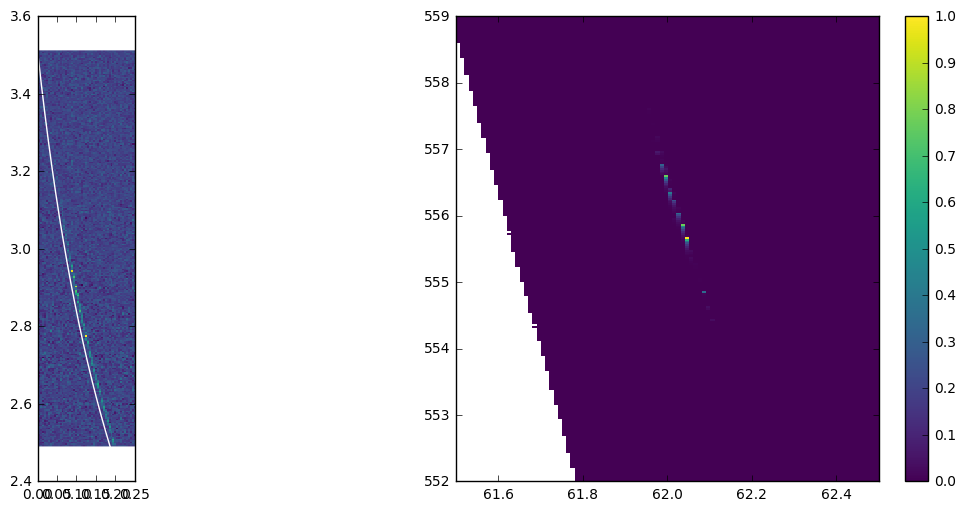

In [337]:
# find bounds
ci = 0.95
dmb, tb = np.where(grid > 1-ci)
dmm, tm = np.where(grid == grid.max())
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
print('Max at DM={0}'.format(dms[dmm[0]]))
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

pl.figure(figsize=(15,6))
pl.subplot(121)
t0 = int(times[0])
dt = 50*st['inttime']
extent = (0, dt, st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,t0:t0+50], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.plot(delay(dms[dmm[0]], 2, st['freq']), st['freq'], 'w-')
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis',
          extent=extent, aspect='auto')
pl.colorbar()

In [338]:
key = '57645'
# forced to use broader spectral model. not ideal...

st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(dmmax[key][1]-2, dmmax[key][1]+2, 100)
dms=np.linspace(520, 620, 200)
#grid = sample(sgram, spectrumwide[key].mean(axis=0)[None,:], st['freq'], times=times, dms=dms, rescale=1.1)[:,:,0]
grid = sample(sgram, [8, 70, 40], st['freq'], times=times, dms=dms)[:,:,0]
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal((grid/grid.max()).transpose(), 0) # normalize and flip to get time horizontally

2016-12-20 18:22:18,335 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0700776701543
(100, 200) 2.79272894526e-40 1.0


18.7373737374 19.0606060606 522.010050251 554.170854271
Max at DM=551.658291457


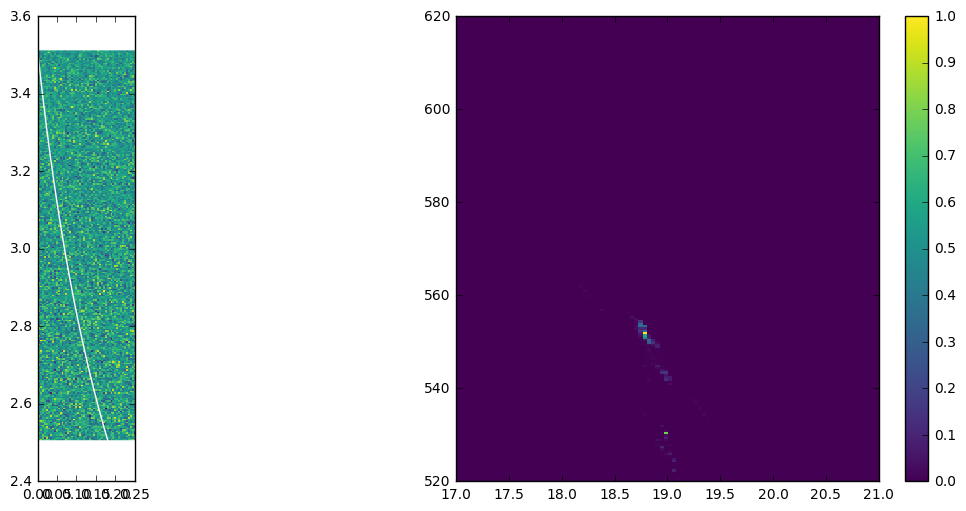

In [339]:
# find bounds
ci = 0.95
dmb, tb = np.where(grid > 1-ci)
dmm, tm = np.where(grid == grid.max())
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
print('Max at DM={0}'.format(dms[dmm[0]]))
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

pl.figure(figsize=(15,6))
pl.subplot(121)
t0 = int(times[0])
dt = 50*st['inttime']
extent = (0, dt, st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,t0:t0+50], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.plot(delay(dms[dmm[0]], 2, st['freq']), st['freq'], 'w-')
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis',
          extent=extent, aspect='auto')
pl.colorbar()

In [340]:
key = '57646'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(dmmax[key][1]-0.7, dmmax[key][1], 100)
dms=np.linspace(555, 570, 200)
#grid = sample(sgram, spectrumwide[key].mean(axis=0)[None,:], st['freq'], times=times, dms=dms, rescale=1.1)[:,:,0]
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms)[:,:,0]
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal((grid/grid.max()).transpose(), 0) # normalize and flip to get time horizontally

2016-12-20 18:23:56,659 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0649333444994
(100, 200) 1.26430217928e-60 1.0


47.4909090909 47.5545454545 561.030150754 562.688442211
Max at DM=561.783919598


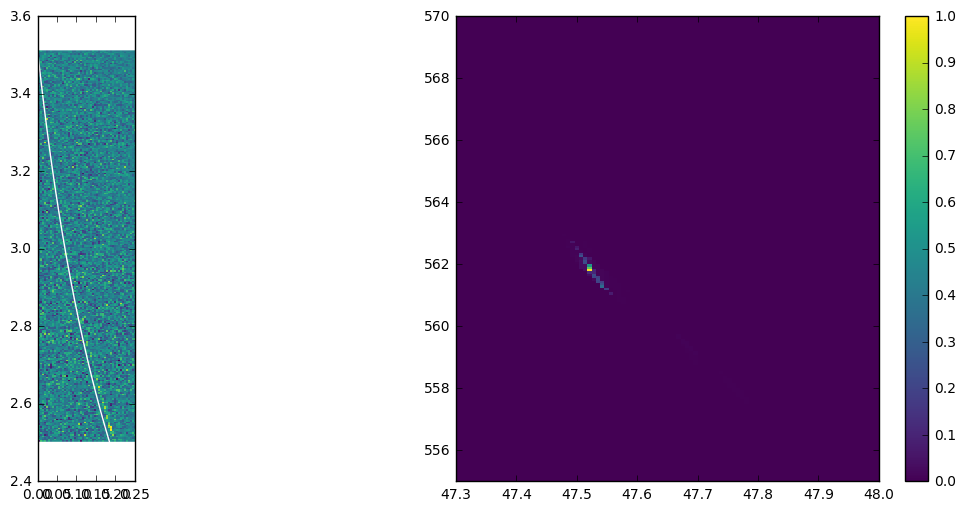

In [341]:
# find bounds
ci = 0.95
dmb, tb = np.where(grid > 1-ci)
dmm, tm = np.where(grid == grid.max())
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
print('Max at DM={0}'.format(dms[dmm[0]]))
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

pl.figure(figsize=(15,6))
pl.subplot(121)
t0 = int(times[0])
dt = 50*st['inttime']
extent = (0, dt, st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,t0:t0+50], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.plot(delay(dms[dmm[0]], 2, st['freq']), st['freq'], 'w-')
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis',
          extent=extent, aspect='auto')
pl.colorbar()

In [342]:
key = '57648'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(dmmax[key][1], dmmax[key][1]+1, 100)
dms=np.linspace(530, 560, 250)
#grid = sample(sgram, spectrumwide[key].mean(axis=0)[None,:], st['freq'], times=times, dms=dms, rescale=1.1)[:,:,0]
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms)[:,:,0]
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal((grid/grid.max()).transpose(), 0) # normalize and flip to get time horizontally

2016-12-20 18:25:35,201 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0690860645985
(100, 250) 1.65022768013e-74 1.0


44.3737373737 44.7272727273 535.662650602 548.795180723
Max at DM=546.626506024


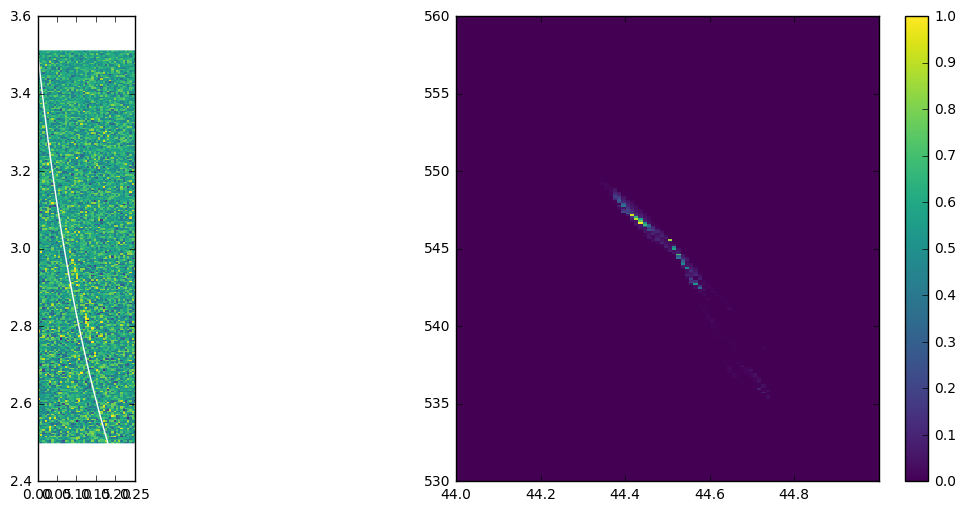

In [343]:
# find bounds
ci = 0.95
dmb, tb = np.where(grid > 1-ci)
dmm, tm = np.where(grid == grid.max())
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
print('Max at DM={0}'.format(dms[dmm[0]]))
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

pl.figure(figsize=(15,6))
pl.subplot(121)
t0 = int(times[0])
dt = 50*st['inttime']
extent = (0, dt, st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,t0:t0+50], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.plot(delay(dms[dmm[0]], 2, st['freq']), st['freq'], 'w-')
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis',
          extent=extent, aspect='auto')
pl.colorbar()

In [344]:
key = '57649'
st, data, u, v, w = read[key]
scale = getscale(st)
sgram = correctdata(st, data*scale, u, v, w, corr='ph').mean(axis=3).mean(axis=1).real.transpose()

times=np.linspace(dmmax[key][1]+0.2, dmmax[key][1]+0.6, 100)
dms=np.linspace(540, 560, 250)
#grid = sample(sgram, spectrumwide[key].mean(axis=0)[None,:], st['freq'], times=times, dms=dms, rescale=1.1)[:,:,0]
grid = sample(sgram, popt[key], st['freq'], times=times, dms=dms)[:,:,0]
print(grid.shape, grid.min(), grid.max())
grid = np.ma.masked_equal((grid/grid.max()).transpose(), 0) # normalize and flip to get time horizontally

2016-12-20 18:27:37,260 - py.warnings - WARNING - /users/claw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Noise from MAD: 0.0690187424866
(100, 250) 3.35500579752e-25 1.0


45.397979798 45.5232323232 544.016064257 548.835341365
Max at DM=546.907630522


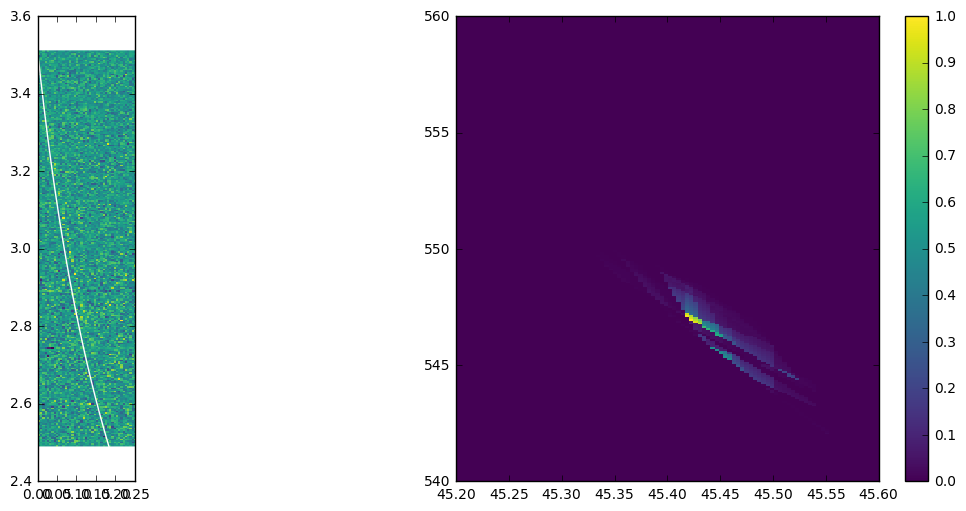

In [345]:
# find bounds
ci = 0.95
dmb, tb = np.where(grid > 1-ci)
dmm, tm = np.where(grid == grid.max())
print(times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])
print('Max at DM={0}'.format(dms[dmm[0]]))
spec_ci[key] = (times[tb].min(), times[tb.max()], dms[dmb.min()], dms[dmb.max()])

pl.figure(figsize=(15,6))
pl.subplot(121)
t0 = int(times[0])
dt = 50*st['inttime']
extent = (0, dt, st['freq'][0], st['freq'][-1])
pl.imshow(sgram[:,t0:t0+50], interpolation='nearest', origin='lower', cmap='viridis',
          vmax=sgram.max()*0.8, extent=extent)
pl.plot(delay(dms[dmm[0]], 2, st['freq']), st['freq'], 'w-')
pl.subplot(122)
extent = (times.min(), times.max(), dms.min(), dms.max())
pl.imshow(grid, interpolation='nearest', origin='lower', cmap='viridis',
          extent=extent, aspect='auto')
pl.colorbar()

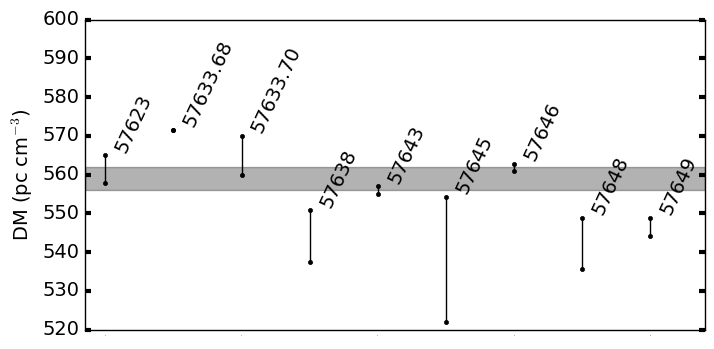

In [346]:
pl.figure(figsize=(8,4))
ax = pl.subplot(111)
i=0
keys = ['57623', '57633_scan7', '57633_scan13', '57638', '57643', '57645', '57646', '57648', '57649']
label = ['57623', '57633.68', '57633.70', '57638', '57643', '57645', '57646', '57648', '57649']
for key in keys:
    try:
        t0, t1, d0, d1 = spec_ci[key]
        pl.plot([i, i], [d0, d1], '.-k')
        pl.text(i+0.1, min(d1, 610), str(label[i]), rotation=65, fontsize=14, verticalalignment='bottom')
    except:
        print('key {0} not found'.format(key))
        pass
    i += 1

#pl.plot([0,i], [557, 557], 'k--')
ax.axhspan(556, 562, alpha=0.3, color='k')
pl.xlim(-0.3,8.8)
pl.ylim(520,600)
pl.ylabel('DM (pc cm$^{-3}$)', fontsize=14)
xt = pl.setp(ax.get_xticklabels(), fontsize=0)
yt = pl.setp(ax.get_yticklabels(), fontsize=14)
ax.xaxis.set_tick_params(width=0, color='k')
ax.yaxis.set_tick_params(width=3, color='k')